# Document classification on RVL-CDIP Dataset

The RVL-CDIP (Ryerson Vision Lab Complex Document Information Processing) dataset consists of 400,000 grayscale images in 16 classes, with 25,000 images per class. There are 320,000 training images, 40,000 validation images, and 40,000 test images. The images are sized so their largest dimension does not exceed 1000 pixels.

Here are the classes in the dataset, and an example from each:

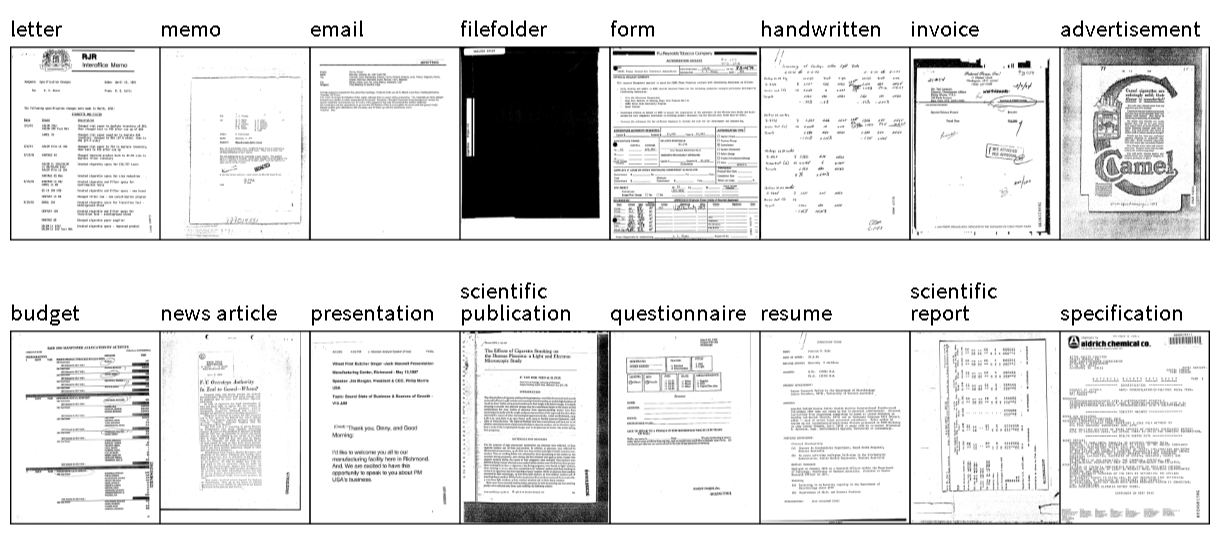

reference: http://www.cs.cmu.edu/~aharley/rvl-cdip/

A. W. Harley, A. Ufkes, K. G. Derpanis, "Evaluation of Deep Convolutional Nets for Document Image Classification and Retrieval," in ICDAR, 2015, <a href="http://www.cs.cmu.edu/~aharley/icdar15">[Link to paper]</a>

## 1. Data preparation

I have downloaded and extraxted the data. Uncompressed dataset was having size of 38 GB and after compressing, it is of 100 GBs.

It primirally has two folders, one containing images and other containing labels file. The label files list the images and their categories in the following format:

path/to/the/image.tif category

where the categories are numbered 0 to 15, in the following order:

0. letter
1. form
2. email
3. handwritten
4. advertisement
5. scientific report
6. scientific publication
7. specification
8. file folder
9. news article
10. budget
11. invoice
12. presentation
13. questionnaire
14. resume
15. memo

As mentioned above, the size of data is around 100 GBs and that's why it is not possible to proceess this dataset entirely using RAM. 

So, I will build a folder structure to extract batches while training. The structure would lokk like something below.

- Train Data/
    - 0/
    - 1/
    - 2/
    - ../
    - ../
- Validation Data/
    - 0/
    - 1/
    - 2/
    - ../
    - ../
- Test Data/
    - 0/
    - 1/
    - 2/
    - ../
    - ../
    


In [1]:
import pandas as pd
import numpy  as np
import shutil
import os
from PIL import Image 
from tqdm import tqdm_notebook as tqdm

In [37]:
# building train data folder

fh = open('labels/train.txt') # opening text file containing train data images
for line in tqdm(fh): # for each line
    pth, cls = line.split(' ') # separate a line by space to get image path and class
    src = 'images/'+pth # current image path
    cls=cls.strip() 
    dst = 'traindata/'+cls+'/' # destination image path
    try:
        os.makedirs(dst) # make directory if do not exists
    except:
        pass
    img = Image.open(src) 
    name = pth.split("/")[-1] # get image name
    name = str(name).rstrip(".tif") # remove tif
    outfile = dst+name + '.jpg' 
    out = img.convert("L")
    out.save(outfile, "JPEG", quality=100) # save image as JPEG 
fh.close()

In [38]:
# building validation data folder

fh = open('labels/val.txt')
for line in tqdm(fh):
    pth, cls = line.split(' ')
    src = 'images/'+pth
    cls=cls.strip()
    dst = 'valdata/'+cls+'/'
    try:
        os.makedirs(dst)
    except:
        pass
    img = Image.open(src)
    name = pth.split("/")[-1]
    name = str(name).rstrip(".tif")
    outfile = dst+name + '.jpg'
    out = img.convert("L")
    out.save(outfile, "JPEG", quality=100)
fh.close()

In [3]:
# building test data folder

fh = open('labels/test.txt')
for line in tqdm(fh):
    pth, cls = line.split(' ')
    src = 'images/'+pth
    cls=cls.strip()
    dst = 'testdata/'+cls+'/'
    try:
        os.makedirs(dst)
    except:
        pass
    
    try:
        img = Image.open(src)
        name = pth.split("/")[-1]
        name = str(name).rstrip(".tif")
        outfile = dst+name + '.jpg'
        out = img.convert("L")
        out.save(outfile, "JPEG", quality=100)
    except:
        pass
fh.close()

C:\Users\91814\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


uint8
(1000, 754)


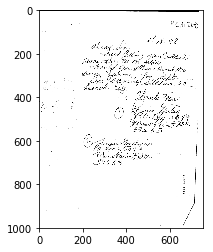

In [3]:
# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
data = image.imread('traindata/3/518223252+-3253.jpg')
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
pyplot.imshow(data, cmap="gray")
pyplot.show()

## 2. Understanding Data

By examining dataset, I found below insights about dataset:

1. Valid Train Images: 319835 
2. Valid Validation Images: 39995 
3. Valid Testin Images: 39996
4. Classes are pretty much distributed equially across all class for Train, Validation and Test dataset and thus, <b>strongly balanced dataset</b>
5. All images are having height of 1000 pixels, mostly are having size of 1000x752 pixels (ref: https://github.com/jpcrum/Final-Project-Group5)

## 3. Why Document Classification

Many document types have a distinct visual style. For example, “letter” documents are typically written in a standard
format, which is recognizable even at scales where the text is unreadable. 

Motivated by this observation, this paper addresses the problem of document classification and retrieval, based on the visual structure and layout of document images. 

Content-based analysis of document images has a number of applications. In digital libraries, documents are often stored as images before they are processed by an optical character
recognition (OCR) system, which means image analysis is
the only available tool for initial indexing and classification. 

As a pre-processing stage, document image analysis can
facilitate and improve OCR by providing information about
each document’s visual layout. 

Furthermore, document
information that is lost in OCR, such as typeface, graphics,
and layout, is often stored and indexed using images or image
descriptors. Therefore, image analysis is complementary to
OCR at several stages of document analysis.

The challenge of document image analysis arises from
the fact that within each document type, there exists a wide
range of visual variability. Intra-class variability
renders spatial layout analysis difficult, and template-based
matching impossible. 

Another issue is that documents of
different categories often have substantial visual similarities.
For instance, there exist advertisements that look like news articles, and questionnaires that look like forms, and so on. 

From
the perspective of “visual styles”, some erroneous retrievals in
such circumstances may be justifiable, but in general the task of
document image analysis is to classify and retrieve documents
despite intra-class variability, and inter-class similarity.
 
Information borowed from: http://www.cs.cmu.edu/~aharley/icdar15/harley_convnet_icdar15.pdf

## 4. A Quick  Deep Learning Experiement with Simple Architecture

For quick experiment, we will use an architecture with 3 convolutional layer followed by max pooling layers and then FC layer followed by output layer.

I will use input image size of 500x376 along with batch size of 32

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.models import Model

Using TensorFlow backend.


In [7]:
img_width= 500
img_height= 376
batch_size= 32

In [8]:
inp = Input(shape=(img_width, img_height, 1))
x = Conv2D(32, (3, 3), activation='relu')(inp)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

out = Dense(16, activation='softmax')(x)
model = Model(inputs=inp, outputs=out)


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500, 376, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 498, 374, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 249, 187, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 247, 185, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 123, 92, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 121, 90, 64)       18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 60, 45, 64)        0         
__________

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1. / 255) # generating a normalized (scaled) image

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)


In [12]:

train_generator = train_datagen.flow_from_directory(
    'traindata/',
    target_size=(img_width, img_height), # target image size 500x376
    color_mode='grayscale', # image with one channel
    batch_size=batch_size,
    class_mode='categorical') # categories will be based on folder name of an image

validation_generator = test_datagen.flow_from_directory(
    'valdata/',
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical')

Found 319835 images belonging to 16 classes.
Found 39995 images belonging to 16 classes.


In [13]:
model.fit_generator(
    train_generator,
    epochs=1,
    validation_data=validation_generator,
    verbose=1,
    steps_per_epoch=319835//batch_size,
    validation_steps=39995//batch_size)


Epoch 1/1


 194/9994 [..............................] - ETA: 23:41:40 - loss: 2.7697 - acc: 0.062 - ETA: 12:06:42 - loss: 5.9001 - acc: 0.046 - ETA: 8:15:01 - loss: 6.1181 - acc: 0.072 - ETA: 6:19:06 - loss: 5.5947 - acc: 0.06 - ETA: 5:39:17 - loss: 5.0827 - acc: 0.06 - ETA: 5:35:42 - loss: 4.7186 - acc: 0.06 - ETA: 5:31:16 - loss: 4.4316 - acc: 0.06 - ETA: 5:33:22 - loss: 4.2364 - acc: 0.06 - ETA: 5:31:09 - loss: 4.0777 - acc: 0.06 - ETA: 5:17:06 - loss: 3.9438 - acc: 0.07 - ETA: 5:03:30 - loss: 3.8384 - acc: 0.06 - ETA: 4:53:32 - loss: 3.7497 - acc: 0.07 - ETA: 4:46:14 - loss: 3.6811 - acc: 0.06 - ETA: 4:38:31 - loss: 3.6163 - acc: 0.06 - ETA: 4:34:19 - loss: 3.5619 - acc: 0.06 - ETA: 4:29:12 - loss: 3.5129 - acc: 0.06 - ETA: 4:25:51 - loss: 3.4688 - acc: 0.06 - ETA: 4:20:58 - loss: 3.4299 - acc: 0.06 - ETA: 4:18:10 - loss: 3.3936 - acc: 0.06 - ETA: 4:14:48 - loss: 3.3628 - acc: 0.06 - ETA: 4:11:31 - loss: 3.3376 - acc: 0.05 - ETA: 4:09:27 - loss: 3.3129 - acc: 0.05 - ETA: 4:07:05 - loss: 3.289

2729/9994 [=======>......................] - ETA: 5:57:05 - loss: 2.0557 - acc: 0.34 - ETA: 5:57:08 - loss: 2.0556 - acc: 0.34 - ETA: 5:57:03 - loss: 2.0556 - acc: 0.34 - ETA: 5:56:56 - loss: 2.0555 - acc: 0.34 - ETA: 5:56:56 - loss: 2.0553 - acc: 0.34 - ETA: 5:56:49 - loss: 2.0552 - acc: 0.34 - ETA: 5:56:42 - loss: 2.0552 - acc: 0.34 - ETA: 5:56:45 - loss: 2.0549 - acc: 0.34 - ETA: 5:56:47 - loss: 2.0548 - acc: 0.34 - ETA: 5:56:43 - loss: 2.0546 - acc: 0.34 - ETA: 5:56:39 - loss: 2.0546 - acc: 0.34 - ETA: 5:56:37 - loss: 2.0545 - acc: 0.34 - ETA: 5:56:29 - loss: 2.0543 - acc: 0.34 - ETA: 5:56:29 - loss: 2.0542 - acc: 0.34 - ETA: 5:56:27 - loss: 2.0542 - acc: 0.34 - ETA: 5:56:24 - loss: 2.0540 - acc: 0.34 - ETA: 5:56:18 - loss: 2.0539 - acc: 0.34 - ETA: 5:56:11 - loss: 2.0538 - acc: 0.34 - ETA: 5:56:03 - loss: 2.0537 - acc: 0.34 - ETA: 5:56:05 - loss: 2.0535 - acc: 0.34 - ETA: 5:55:59 - loss: 2.0532 - acc: 0.34 - ETA: 5:55:52 - loss: 2.0531 - acc: 0.34 - ETA: 5:55:48 - loss: 2.0530 - a

2924/9994 [=======>......................] - ETA: 5:43:35 - loss: 2.0349 - acc: 0.35 - ETA: 5:43:29 - loss: 2.0346 - acc: 0.35 - ETA: 5:43:26 - loss: 2.0348 - acc: 0.35 - ETA: 5:43:19 - loss: 2.0346 - acc: 0.35 - ETA: 5:43:15 - loss: 2.0345 - acc: 0.35 - ETA: 5:43:19 - loss: 2.0345 - acc: 0.35 - ETA: 5:43:12 - loss: 2.0344 - acc: 0.35 - ETA: 5:43:09 - loss: 2.0342 - acc: 0.35 - ETA: 5:43:06 - loss: 2.0342 - acc: 0.35 - ETA: 5:42:59 - loss: 2.0341 - acc: 0.35 - ETA: 5:42:55 - loss: 2.0340 - acc: 0.35 - ETA: 5:42:51 - loss: 2.0339 - acc: 0.35 - ETA: 5:42:45 - loss: 2.0338 - acc: 0.35 - ETA: 5:42:40 - loss: 2.0337 - acc: 0.35 - ETA: 5:42:35 - loss: 2.0336 - acc: 0.35 - ETA: 5:42:31 - loss: 2.0334 - acc: 0.35 - ETA: 5:42:27 - loss: 2.0335 - acc: 0.35 - ETA: 5:42:21 - loss: 2.0333 - acc: 0.35 - ETA: 5:42:14 - loss: 2.0333 - acc: 0.35 - ETA: 5:42:13 - loss: 2.0331 - acc: 0.35 - ETA: 5:42:08 - loss: 2.0330 - acc: 0.35 - ETA: 5:42:03 - loss: 2.0329 - acc: 0.35 - ETA: 5:41:58 - loss: 2.0327 - a

3119/9994 [========>.....................] - ETA: 5:30:09 - loss: 2.0133 - acc: 0.35 - ETA: 5:30:05 - loss: 2.0132 - acc: 0.35 - ETA: 5:30:00 - loss: 2.0130 - acc: 0.35 - ETA: 5:29:54 - loss: 2.0129 - acc: 0.35 - ETA: 5:29:50 - loss: 2.0128 - acc: 0.35 - ETA: 5:29:45 - loss: 2.0128 - acc: 0.35 - ETA: 5:29:46 - loss: 2.0127 - acc: 0.35 - ETA: 5:29:41 - loss: 2.0127 - acc: 0.35 - ETA: 5:29:39 - loss: 2.0127 - acc: 0.35 - ETA: 5:29:34 - loss: 2.0126 - acc: 0.35 - ETA: 5:29:28 - loss: 2.0124 - acc: 0.35 - ETA: 5:29:23 - loss: 2.0123 - acc: 0.35 - ETA: 5:29:17 - loss: 2.0122 - acc: 0.35 - ETA: 5:29:11 - loss: 2.0120 - acc: 0.35 - ETA: 5:29:09 - loss: 2.0118 - acc: 0.35 - ETA: 5:29:03 - loss: 2.0116 - acc: 0.35 - ETA: 5:28:57 - loss: 2.0115 - acc: 0.35 - ETA: 5:28:53 - loss: 2.0115 - acc: 0.35 - ETA: 5:28:48 - loss: 2.0114 - acc: 0.35 - ETA: 5:28:50 - loss: 2.0114 - acc: 0.35 - ETA: 5:28:47 - loss: 2.0113 - acc: 0.35 - ETA: 5:28:45 - loss: 2.0112 - acc: 0.35 - ETA: 5:28:48 - loss: 2.0112 - a

3314/9994 [========>.....................] - ETA: 5:18:38 - loss: 1.9924 - acc: 0.36 - ETA: 5:18:32 - loss: 1.9922 - acc: 0.36 - ETA: 5:18:30 - loss: 1.9922 - acc: 0.36 - ETA: 5:18:31 - loss: 1.9922 - acc: 0.36 - ETA: 5:18:27 - loss: 1.9920 - acc: 0.36 - ETA: 5:18:21 - loss: 1.9919 - acc: 0.36 - ETA: 5:18:19 - loss: 1.9917 - acc: 0.36 - ETA: 5:18:15 - loss: 1.9916 - acc: 0.36 - ETA: 5:18:11 - loss: 1.9914 - acc: 0.36 - ETA: 5:18:07 - loss: 1.9913 - acc: 0.36 - ETA: 5:18:00 - loss: 1.9911 - acc: 0.36 - ETA: 5:18:00 - loss: 1.9912 - acc: 0.36 - ETA: 5:17:55 - loss: 1.9911 - acc: 0.36 - ETA: 5:17:50 - loss: 1.9911 - acc: 0.36 - ETA: 5:17:45 - loss: 1.9910 - acc: 0.36 - ETA: 5:17:51 - loss: 1.9908 - acc: 0.36 - ETA: 5:17:50 - loss: 1.9907 - acc: 0.36 - ETA: 5:17:44 - loss: 1.9906 - acc: 0.36 - ETA: 5:17:39 - loss: 1.9905 - acc: 0.36 - ETA: 5:17:35 - loss: 1.9905 - acc: 0.36 - ETA: 5:17:30 - loss: 1.9905 - acc: 0.36 - ETA: 5:17:32 - loss: 1.9903 - acc: 0.36 - ETA: 5:17:28 - loss: 1.9902 - a

3509/9994 [=========>....................] - ETA: 5:07:24 - loss: 1.9751 - acc: 0.36 - ETA: 5:07:22 - loss: 1.9749 - acc: 0.36 - ETA: 5:07:16 - loss: 1.9749 - acc: 0.36 - ETA: 5:07:12 - loss: 1.9748 - acc: 0.36 - ETA: 5:07:09 - loss: 1.9747 - acc: 0.36 - ETA: 5:07:04 - loss: 1.9745 - acc: 0.36 - ETA: 5:07:04 - loss: 1.9743 - acc: 0.36 - ETA: 5:06:59 - loss: 1.9742 - acc: 0.36 - ETA: 5:07:03 - loss: 1.9741 - acc: 0.36 - ETA: 5:06:58 - loss: 1.9740 - acc: 0.36 - ETA: 5:06:56 - loss: 1.9739 - acc: 0.36 - ETA: 5:06:53 - loss: 1.9738 - acc: 0.36 - ETA: 5:06:50 - loss: 1.9736 - acc: 0.36 - ETA: 5:06:52 - loss: 1.9736 - acc: 0.36 - ETA: 5:06:48 - loss: 1.9735 - acc: 0.36 - ETA: 5:06:43 - loss: 1.9733 - acc: 0.36 - ETA: 5:06:39 - loss: 1.9732 - acc: 0.36 - ETA: 5:06:34 - loss: 1.9733 - acc: 0.36 - ETA: 5:06:36 - loss: 1.9731 - acc: 0.36 - ETA: 5:06:31 - loss: 1.9730 - acc: 0.36 - ETA: 5:06:27 - loss: 1.9731 - acc: 0.36 - ETA: 5:06:26 - loss: 1.9729 - acc: 0.36 - ETA: 5:06:21 - loss: 1.9727 - a

3704/9994 [==========>...................] - ETA: 4:57:18 - loss: 1.9571 - acc: 0.37 - ETA: 4:57:18 - loss: 1.9570 - acc: 0.37 - ETA: 4:57:16 - loss: 1.9569 - acc: 0.37 - ETA: 4:57:10 - loss: 1.9569 - acc: 0.37 - ETA: 4:57:05 - loss: 1.9568 - acc: 0.37 - ETA: 4:56:59 - loss: 1.9568 - acc: 0.37 - ETA: 4:56:54 - loss: 1.9567 - acc: 0.37 - ETA: 4:56:49 - loss: 1.9567 - acc: 0.37 - ETA: 4:56:45 - loss: 1.9567 - acc: 0.37 - ETA: 4:56:39 - loss: 1.9566 - acc: 0.37 - ETA: 4:56:35 - loss: 1.9566 - acc: 0.37 - ETA: 4:56:29 - loss: 1.9566 - acc: 0.37 - ETA: 4:56:24 - loss: 1.9564 - acc: 0.37 - ETA: 4:56:18 - loss: 1.9563 - acc: 0.37 - ETA: 4:56:13 - loss: 1.9561 - acc: 0.37 - ETA: 4:56:07 - loss: 1.9560 - acc: 0.37 - ETA: 4:56:06 - loss: 1.9560 - acc: 0.37 - ETA: 4:56:04 - loss: 1.9558 - acc: 0.37 - ETA: 4:56:01 - loss: 1.9558 - acc: 0.37 - ETA: 4:55:57 - loss: 1.9557 - acc: 0.37 - ETA: 4:55:52 - loss: 1.9556 - acc: 0.37 - ETA: 4:55:48 - loss: 1.9556 - acc: 0.37 - ETA: 4:55:44 - loss: 1.9554 - a

3899/9994 [==========>...................] - ETA: 4:46:43 - loss: 1.9407 - acc: 0.37 - ETA: 4:46:38 - loss: 1.9407 - acc: 0.37 - ETA: 4:46:33 - loss: 1.9407 - acc: 0.37 - ETA: 4:46:30 - loss: 1.9406 - acc: 0.37 - ETA: 4:46:29 - loss: 1.9405 - acc: 0.37 - ETA: 4:46:27 - loss: 1.9404 - acc: 0.37 - ETA: 4:46:26 - loss: 1.9403 - acc: 0.37 - ETA: 4:46:23 - loss: 1.9402 - acc: 0.37 - ETA: 4:46:19 - loss: 1.9402 - acc: 0.37 - ETA: 4:46:14 - loss: 1.9402 - acc: 0.37 - ETA: 4:46:11 - loss: 1.9400 - acc: 0.37 - ETA: 4:46:09 - loss: 1.9399 - acc: 0.37 - ETA: 4:46:05 - loss: 1.9397 - acc: 0.37 - ETA: 4:46:00 - loss: 1.9396 - acc: 0.37 - ETA: 4:45:55 - loss: 1.9395 - acc: 0.37 - ETA: 4:46:13 - loss: 1.9394 - acc: 0.37 - ETA: 4:46:09 - loss: 1.9393 - acc: 0.37 - ETA: 4:46:04 - loss: 1.9392 - acc: 0.37 - ETA: 4:45:59 - loss: 1.9391 - acc: 0.37 - ETA: 4:45:54 - loss: 1.9388 - acc: 0.37 - ETA: 4:45:48 - loss: 1.9389 - acc: 0.37 - ETA: 4:45:43 - loss: 1.9388 - acc: 0.37 - ETA: 4:45:38 - loss: 1.9386 - a

4094/9994 [===========>..................] - ETA: 4:36:02 - loss: 1.9245 - acc: 0.38 - ETA: 4:35:59 - loss: 1.9243 - acc: 0.38 - ETA: 4:35:57 - loss: 1.9242 - acc: 0.38 - ETA: 4:35:53 - loss: 1.9240 - acc: 0.38 - ETA: 4:35:50 - loss: 1.9239 - acc: 0.38 - ETA: 4:35:45 - loss: 1.9238 - acc: 0.38 - ETA: 4:35:40 - loss: 1.9238 - acc: 0.38 - ETA: 4:35:36 - loss: 1.9237 - acc: 0.38 - ETA: 4:35:33 - loss: 1.9236 - acc: 0.38 - ETA: 4:35:28 - loss: 1.9236 - acc: 0.38 - ETA: 4:35:23 - loss: 1.9236 - acc: 0.38 - ETA: 4:35:19 - loss: 1.9234 - acc: 0.38 - ETA: 4:35:17 - loss: 1.9234 - acc: 0.38 - ETA: 4:35:14 - loss: 1.9233 - acc: 0.38 - ETA: 4:35:09 - loss: 1.9233 - acc: 0.38 - ETA: 4:35:08 - loss: 1.9232 - acc: 0.38 - ETA: 4:35:05 - loss: 1.9231 - acc: 0.38 - ETA: 4:35:04 - loss: 1.9230 - acc: 0.38 - ETA: 4:34:59 - loss: 1.9229 - acc: 0.38 - ETA: 4:34:55 - loss: 1.9229 - acc: 0.38 - ETA: 4:34:54 - loss: 1.9227 - acc: 0.38 - ETA: 4:34:50 - loss: 1.9226 - acc: 0.38 - ETA: 4:34:46 - loss: 1.9225 - a

4289/9994 [===========>..................] - ETA: 4:26:00 - loss: 1.9098 - acc: 0.38 - ETA: 4:25:55 - loss: 1.9096 - acc: 0.38 - ETA: 4:25:51 - loss: 1.9095 - acc: 0.38 - ETA: 4:25:48 - loss: 1.9094 - acc: 0.38 - ETA: 4:25:45 - loss: 1.9094 - acc: 0.38 - ETA: 4:25:40 - loss: 1.9092 - acc: 0.38 - ETA: 4:25:36 - loss: 1.9092 - acc: 0.38 - ETA: 4:25:32 - loss: 1.9091 - acc: 0.38 - ETA: 4:25:29 - loss: 1.9090 - acc: 0.38 - ETA: 4:25:25 - loss: 1.9089 - acc: 0.38 - ETA: 4:25:21 - loss: 1.9089 - acc: 0.38 - ETA: 4:25:16 - loss: 1.9089 - acc: 0.38 - ETA: 4:25:14 - loss: 1.9088 - acc: 0.38 - ETA: 4:25:09 - loss: 1.9088 - acc: 0.38 - ETA: 4:25:05 - loss: 1.9086 - acc: 0.38 - ETA: 4:25:02 - loss: 1.9086 - acc: 0.38 - ETA: 4:25:00 - loss: 1.9087 - acc: 0.38 - ETA: 4:24:57 - loss: 1.9086 - acc: 0.38 - ETA: 4:24:54 - loss: 1.9085 - acc: 0.38 - ETA: 4:24:50 - loss: 1.9083 - acc: 0.38 - ETA: 4:24:45 - loss: 1.9083 - acc: 0.38 - ETA: 4:24:41 - loss: 1.9082 - acc: 0.38 - ETA: 4:24:36 - loss: 1.9081 - a

4484/9994 [============>.................] - ETA: 4:15:33 - loss: 1.8966 - acc: 0.39 - ETA: 4:15:31 - loss: 1.8966 - acc: 0.39 - ETA: 4:15:26 - loss: 1.8965 - acc: 0.39 - ETA: 4:15:26 - loss: 1.8965 - acc: 0.39 - ETA: 4:15:21 - loss: 1.8964 - acc: 0.39 - ETA: 4:15:17 - loss: 1.8962 - acc: 0.39 - ETA: 4:15:14 - loss: 1.8962 - acc: 0.39 - ETA: 4:15:11 - loss: 1.8962 - acc: 0.39 - ETA: 4:15:11 - loss: 1.8960 - acc: 0.39 - ETA: 4:15:07 - loss: 1.8959 - acc: 0.39 - ETA: 4:15:06 - loss: 1.8960 - acc: 0.39 - ETA: 4:15:01 - loss: 1.8959 - acc: 0.39 - ETA: 4:15:02 - loss: 1.8959 - acc: 0.39 - ETA: 4:14:59 - loss: 1.8958 - acc: 0.39 - ETA: 4:14:54 - loss: 1.8957 - acc: 0.39 - ETA: 4:14:53 - loss: 1.8956 - acc: 0.39 - ETA: 4:14:49 - loss: 1.8955 - acc: 0.39 - ETA: 4:14:46 - loss: 1.8955 - acc: 0.39 - ETA: 4:14:43 - loss: 1.8954 - acc: 0.39 - ETA: 4:14:39 - loss: 1.8953 - acc: 0.39 - ETA: 4:14:36 - loss: 1.8952 - acc: 0.39 - ETA: 4:14:31 - loss: 1.8951 - acc: 0.39 - ETA: 4:14:27 - loss: 1.8950 - a

4679/9994 [=============>................] - ETA: 4:06:20 - loss: 1.8829 - acc: 0.39 - ETA: 4:06:17 - loss: 1.8829 - acc: 0.39 - ETA: 4:06:14 - loss: 1.8828 - acc: 0.39 - ETA: 4:06:10 - loss: 1.8827 - acc: 0.39 - ETA: 4:06:06 - loss: 1.8825 - acc: 0.39 - ETA: 4:06:03 - loss: 1.8826 - acc: 0.39 - ETA: 4:05:59 - loss: 1.8824 - acc: 0.39 - ETA: 4:05:55 - loss: 1.8824 - acc: 0.39 - ETA: 4:05:51 - loss: 1.8823 - acc: 0.39 - ETA: 4:05:47 - loss: 1.8822 - acc: 0.39 - ETA: 4:05:43 - loss: 1.8822 - acc: 0.39 - ETA: 4:05:39 - loss: 1.8820 - acc: 0.39 - ETA: 4:05:36 - loss: 1.8820 - acc: 0.39 - ETA: 4:05:34 - loss: 1.8819 - acc: 0.39 - ETA: 4:05:33 - loss: 1.8818 - acc: 0.39 - ETA: 4:05:30 - loss: 1.8817 - acc: 0.39 - ETA: 4:05:25 - loss: 1.8817 - acc: 0.39 - ETA: 4:05:24 - loss: 1.8816 - acc: 0.39 - ETA: 4:05:24 - loss: 1.8815 - acc: 0.39 - ETA: 4:05:19 - loss: 1.8815 - acc: 0.39 - ETA: 4:05:16 - loss: 1.8814 - acc: 0.39 - ETA: 4:05:12 - loss: 1.8813 - acc: 0.39 - ETA: 4:05:09 - loss: 1.8813 - a

4874/9994 [=============>................] - ETA: 3:56:51 - loss: 1.8696 - acc: 0.40 - ETA: 3:56:47 - loss: 1.8695 - acc: 0.40 - ETA: 3:56:44 - loss: 1.8693 - acc: 0.40 - ETA: 3:56:40 - loss: 1.8693 - acc: 0.40 - ETA: 3:56:38 - loss: 1.8692 - acc: 0.40 - ETA: 3:56:37 - loss: 1.8691 - acc: 0.40 - ETA: 3:56:33 - loss: 1.8690 - acc: 0.40 - ETA: 3:56:30 - loss: 1.8689 - acc: 0.40 - ETA: 3:56:28 - loss: 1.8688 - acc: 0.40 - ETA: 3:56:25 - loss: 1.8688 - acc: 0.40 - ETA: 3:56:22 - loss: 1.8687 - acc: 0.40 - ETA: 3:56:17 - loss: 1.8686 - acc: 0.40 - ETA: 3:56:14 - loss: 1.8684 - acc: 0.40 - ETA: 3:56:10 - loss: 1.8683 - acc: 0.40 - ETA: 3:56:07 - loss: 1.8683 - acc: 0.40 - ETA: 3:56:05 - loss: 1.8681 - acc: 0.40 - ETA: 3:56:01 - loss: 1.8681 - acc: 0.40 - ETA: 3:55:57 - loss: 1.8680 - acc: 0.40 - ETA: 3:55:54 - loss: 1.8680 - acc: 0.40 - ETA: 3:55:50 - loss: 1.8679 - acc: 0.40 - ETA: 3:55:49 - loss: 1.8678 - acc: 0.40 - ETA: 3:55:45 - loss: 1.8678 - acc: 0.40 - ETA: 3:55:41 - loss: 1.8677 - a

5069/9994 [==============>...............] - ETA: 3:47:42 - loss: 1.8565 - acc: 0.40 - ETA: 3:47:39 - loss: 1.8565 - acc: 0.40 - ETA: 3:47:37 - loss: 1.8564 - acc: 0.40 - ETA: 3:47:33 - loss: 1.8564 - acc: 0.40 - ETA: 3:47:29 - loss: 1.8562 - acc: 0.40 - ETA: 3:47:26 - loss: 1.8562 - acc: 0.40 - ETA: 3:47:22 - loss: 1.8561 - acc: 0.40 - ETA: 3:47:18 - loss: 1.8560 - acc: 0.40 - ETA: 3:47:18 - loss: 1.8561 - acc: 0.40 - ETA: 3:47:15 - loss: 1.8562 - acc: 0.40 - ETA: 3:47:12 - loss: 1.8561 - acc: 0.40 - ETA: 3:47:10 - loss: 1.8561 - acc: 0.40 - ETA: 3:47:10 - loss: 1.8560 - acc: 0.40 - ETA: 3:47:07 - loss: 1.8559 - acc: 0.40 - ETA: 3:47:04 - loss: 1.8558 - acc: 0.40 - ETA: 3:47:00 - loss: 1.8558 - acc: 0.40 - ETA: 3:46:58 - loss: 1.8558 - acc: 0.40 - ETA: 3:46:55 - loss: 1.8558 - acc: 0.40 - ETA: 3:46:51 - loss: 1.8558 - acc: 0.40 - ETA: 3:46:50 - loss: 1.8558 - acc: 0.40 - ETA: 3:46:50 - loss: 1.8558 - acc: 0.40 - ETA: 3:46:46 - loss: 1.8558 - acc: 0.40 - ETA: 3:46:43 - loss: 1.8557 - a

5264/9994 [==============>...............] - ETA: 3:38:55 - loss: 1.8451 - acc: 0.40 - ETA: 3:38:51 - loss: 1.8450 - acc: 0.40 - ETA: 3:38:48 - loss: 1.8449 - acc: 0.40 - ETA: 3:38:44 - loss: 1.8449 - acc: 0.40 - ETA: 3:38:41 - loss: 1.8448 - acc: 0.40 - ETA: 3:38:38 - loss: 1.8448 - acc: 0.40 - ETA: 3:38:35 - loss: 1.8446 - acc: 0.40 - ETA: 3:38:32 - loss: 1.8446 - acc: 0.40 - ETA: 3:38:29 - loss: 1.8446 - acc: 0.40 - ETA: 3:38:25 - loss: 1.8446 - acc: 0.40 - ETA: 3:38:23 - loss: 1.8445 - acc: 0.40 - ETA: 3:38:20 - loss: 1.8444 - acc: 0.40 - ETA: 3:38:16 - loss: 1.8443 - acc: 0.40 - ETA: 3:38:13 - loss: 1.8442 - acc: 0.40 - ETA: 3:38:10 - loss: 1.8442 - acc: 0.40 - ETA: 3:38:08 - loss: 1.8442 - acc: 0.40 - ETA: 3:38:05 - loss: 1.8441 - acc: 0.40 - ETA: 3:38:02 - loss: 1.8441 - acc: 0.40 - ETA: 3:37:58 - loss: 1.8441 - acc: 0.40 - ETA: 3:37:56 - loss: 1.8439 - acc: 0.40 - ETA: 3:37:53 - loss: 1.8439 - acc: 0.40 - ETA: 3:37:49 - loss: 1.8438 - acc: 0.40 - ETA: 3:37:46 - loss: 1.8439 - a

5459/9994 [===============>..............] - ETA: 3:29:33 - loss: 1.8341 - acc: 0.41 - ETA: 3:29:30 - loss: 1.8340 - acc: 0.41 - ETA: 3:29:28 - loss: 1.8339 - acc: 0.41 - ETA: 3:29:25 - loss: 1.8339 - acc: 0.41 - ETA: 3:29:22 - loss: 1.8339 - acc: 0.41 - ETA: 3:29:19 - loss: 1.8338 - acc: 0.41 - ETA: 3:29:17 - loss: 1.8337 - acc: 0.41 - ETA: 3:29:15 - loss: 1.8338 - acc: 0.41 - ETA: 3:29:14 - loss: 1.8337 - acc: 0.41 - ETA: 3:29:11 - loss: 1.8336 - acc: 0.41 - ETA: 3:29:07 - loss: 1.8336 - acc: 0.41 - ETA: 3:29:04 - loss: 1.8335 - acc: 0.41 - ETA: 3:29:00 - loss: 1.8335 - acc: 0.41 - ETA: 3:28:57 - loss: 1.8335 - acc: 0.41 - ETA: 3:28:54 - loss: 1.8334 - acc: 0.41 - ETA: 3:28:53 - loss: 1.8333 - acc: 0.41 - ETA: 3:28:51 - loss: 1.8332 - acc: 0.41 - ETA: 3:28:47 - loss: 1.8331 - acc: 0.41 - ETA: 3:28:44 - loss: 1.8331 - acc: 0.41 - ETA: 3:28:40 - loss: 1.8330 - acc: 0.41 - ETA: 3:28:37 - loss: 1.8330 - acc: 0.41 - ETA: 3:28:34 - loss: 1.8329 - acc: 0.41 - ETA: 3:28:32 - loss: 1.8329 - a

5654/9994 [===============>..............] - ETA: 3:20:31 - loss: 1.8243 - acc: 0.41 - ETA: 3:20:27 - loss: 1.8242 - acc: 0.41 - ETA: 3:20:24 - loss: 1.8241 - acc: 0.41 - ETA: 3:20:21 - loss: 1.8241 - acc: 0.41 - ETA: 3:20:18 - loss: 1.8241 - acc: 0.41 - ETA: 3:20:14 - loss: 1.8241 - acc: 0.41 - ETA: 3:20:12 - loss: 1.8240 - acc: 0.41 - ETA: 3:20:17 - loss: 1.8239 - acc: 0.41 - ETA: 3:20:13 - loss: 1.8239 - acc: 0.41 - ETA: 3:20:10 - loss: 1.8238 - acc: 0.41 - ETA: 3:20:06 - loss: 1.8238 - acc: 0.41 - ETA: 3:20:03 - loss: 1.8238 - acc: 0.41 - ETA: 3:19:59 - loss: 1.8238 - acc: 0.41 - ETA: 3:19:56 - loss: 1.8238 - acc: 0.41 - ETA: 3:19:53 - loss: 1.8238 - acc: 0.41 - ETA: 3:19:51 - loss: 1.8238 - acc: 0.41 - ETA: 3:19:47 - loss: 1.8237 - acc: 0.41 - ETA: 3:19:45 - loss: 1.8237 - acc: 0.41 - ETA: 3:19:43 - loss: 1.8236 - acc: 0.41 - ETA: 3:19:39 - loss: 1.8236 - acc: 0.41 - ETA: 3:19:36 - loss: 1.8236 - acc: 0.41 - ETA: 3:19:33 - loss: 1.8235 - acc: 0.41 - ETA: 3:19:30 - loss: 1.8235 - a

5849/9994 [================>.............] - ETA: 3:11:23 - loss: 1.8141 - acc: 0.42 - ETA: 3:11:20 - loss: 1.8140 - acc: 0.42 - ETA: 3:11:18 - loss: 1.8140 - acc: 0.42 - ETA: 3:11:15 - loss: 1.8140 - acc: 0.42 - ETA: 3:11:12 - loss: 1.8140 - acc: 0.42 - ETA: 3:11:08 - loss: 1.8139 - acc: 0.42 - ETA: 3:11:06 - loss: 1.8139 - acc: 0.42 - ETA: 3:11:03 - loss: 1.8138 - acc: 0.42 - ETA: 3:11:00 - loss: 1.8139 - acc: 0.42 - ETA: 3:10:56 - loss: 1.8139 - acc: 0.42 - ETA: 3:10:53 - loss: 1.8139 - acc: 0.42 - ETA: 3:10:51 - loss: 1.8139 - acc: 0.42 - ETA: 3:10:49 - loss: 1.8138 - acc: 0.42 - ETA: 3:10:46 - loss: 1.8137 - acc: 0.42 - ETA: 3:10:43 - loss: 1.8137 - acc: 0.42 - ETA: 3:10:39 - loss: 1.8137 - acc: 0.42 - ETA: 3:10:36 - loss: 1.8136 - acc: 0.42 - ETA: 3:10:34 - loss: 1.8135 - acc: 0.42 - ETA: 3:10:31 - loss: 1.8134 - acc: 0.42 - ETA: 3:10:28 - loss: 1.8134 - acc: 0.42 - ETA: 3:10:25 - loss: 1.8133 - acc: 0.42 - ETA: 3:10:23 - loss: 1.8133 - acc: 0.42 - ETA: 3:10:20 - loss: 1.8132 - a

6044/9994 [=================>............] - ETA: 3:02:12 - loss: 1.8040 - acc: 0.42 - ETA: 3:02:09 - loss: 1.8040 - acc: 0.42 - ETA: 3:02:06 - loss: 1.8041 - acc: 0.42 - ETA: 3:02:02 - loss: 1.8040 - acc: 0.42 - ETA: 3:02:01 - loss: 1.8040 - acc: 0.42 - ETA: 3:01:59 - loss: 1.8039 - acc: 0.42 - ETA: 3:01:56 - loss: 1.8039 - acc: 0.42 - ETA: 3:01:52 - loss: 1.8038 - acc: 0.42 - ETA: 3:01:50 - loss: 1.8037 - acc: 0.42 - ETA: 3:01:47 - loss: 1.8036 - acc: 0.42 - ETA: 3:01:44 - loss: 1.8036 - acc: 0.42 - ETA: 3:01:41 - loss: 1.8035 - acc: 0.42 - ETA: 3:01:37 - loss: 1.8035 - acc: 0.42 - ETA: 3:01:34 - loss: 1.8034 - acc: 0.42 - ETA: 3:01:37 - loss: 1.8033 - acc: 0.42 - ETA: 3:01:37 - loss: 1.8033 - acc: 0.42 - ETA: 3:01:36 - loss: 1.8032 - acc: 0.42 - ETA: 3:01:34 - loss: 1.8031 - acc: 0.42 - ETA: 3:01:30 - loss: 1.8030 - acc: 0.42 - ETA: 3:01:27 - loss: 1.8030 - acc: 0.42 - ETA: 3:01:25 - loss: 1.8028 - acc: 0.42 - ETA: 3:01:21 - loss: 1.8028 - acc: 0.42 - ETA: 3:01:17 - loss: 1.8028 - a

6239/9994 [=================>............] - ETA: 2:53:12 - loss: 1.7941 - acc: 0.42 - ETA: 2:53:10 - loss: 1.7941 - acc: 0.42 - ETA: 2:53:08 - loss: 1.7941 - acc: 0.42 - ETA: 2:53:05 - loss: 1.7940 - acc: 0.42 - ETA: 2:53:01 - loss: 1.7940 - acc: 0.42 - ETA: 2:52:58 - loss: 1.7940 - acc: 0.42 - ETA: 2:52:55 - loss: 1.7939 - acc: 0.42 - ETA: 2:52:52 - loss: 1.7938 - acc: 0.42 - ETA: 2:52:49 - loss: 1.7938 - acc: 0.42 - ETA: 2:52:47 - loss: 1.7937 - acc: 0.42 - ETA: 2:52:44 - loss: 1.7937 - acc: 0.42 - ETA: 2:52:41 - loss: 1.7937 - acc: 0.42 - ETA: 2:52:38 - loss: 1.7936 - acc: 0.42 - ETA: 2:52:35 - loss: 1.7935 - acc: 0.42 - ETA: 2:52:33 - loss: 1.7934 - acc: 0.42 - ETA: 2:52:30 - loss: 1.7934 - acc: 0.42 - ETA: 2:52:27 - loss: 1.7933 - acc: 0.42 - ETA: 2:52:24 - loss: 1.7932 - acc: 0.42 - ETA: 2:52:21 - loss: 1.7931 - acc: 0.42 - ETA: 2:52:18 - loss: 1.7929 - acc: 0.42 - ETA: 2:52:15 - loss: 1.7928 - acc: 0.42 - ETA: 2:52:12 - loss: 1.7927 - acc: 0.42 - ETA: 2:52:09 - loss: 1.7926 - a

6434/9994 [==================>...........] - ETA: 2:44:23 - loss: 1.7835 - acc: 0.42 - ETA: 2:44:20 - loss: 1.7834 - acc: 0.42 - ETA: 2:44:17 - loss: 1.7833 - acc: 0.43 - ETA: 2:44:13 - loss: 1.7833 - acc: 0.43 - ETA: 2:44:10 - loss: 1.7832 - acc: 0.43 - ETA: 2:44:07 - loss: 1.7831 - acc: 0.43 - ETA: 2:44:05 - loss: 1.7831 - acc: 0.43 - ETA: 2:44:03 - loss: 1.7830 - acc: 0.43 - ETA: 2:44:00 - loss: 1.7830 - acc: 0.43 - ETA: 2:43:56 - loss: 1.7831 - acc: 0.43 - ETA: 2:43:53 - loss: 1.7830 - acc: 0.43 - ETA: 2:43:50 - loss: 1.7830 - acc: 0.43 - ETA: 2:43:48 - loss: 1.7829 - acc: 0.43 - ETA: 2:43:45 - loss: 1.7828 - acc: 0.43 - ETA: 2:43:42 - loss: 1.7828 - acc: 0.43 - ETA: 2:43:39 - loss: 1.7827 - acc: 0.43 - ETA: 2:43:36 - loss: 1.7827 - acc: 0.43 - ETA: 2:43:32 - loss: 1.7827 - acc: 0.43 - ETA: 2:43:29 - loss: 1.7827 - acc: 0.43 - ETA: 2:43:27 - loss: 1.7826 - acc: 0.43 - ETA: 2:43:23 - loss: 1.7826 - acc: 0.43 - ETA: 2:43:22 - loss: 1.7825 - acc: 0.43 - ETA: 2:43:19 - loss: 1.7825 - a

6629/9994 [==================>...........] - ETA: 2:35:25 - loss: 1.7745 - acc: 0.43 - ETA: 2:35:22 - loss: 1.7745 - acc: 0.43 - ETA: 2:35:19 - loss: 1.7744 - acc: 0.43 - ETA: 2:35:16 - loss: 1.7744 - acc: 0.43 - ETA: 2:35:14 - loss: 1.7743 - acc: 0.43 - ETA: 2:35:14 - loss: 1.7743 - acc: 0.43 - ETA: 2:35:10 - loss: 1.7742 - acc: 0.43 - ETA: 2:35:07 - loss: 1.7742 - acc: 0.43 - ETA: 2:35:04 - loss: 1.7741 - acc: 0.43 - ETA: 2:35:02 - loss: 1.7740 - acc: 0.43 - ETA: 2:35:00 - loss: 1.7740 - acc: 0.43 - ETA: 2:34:57 - loss: 1.7740 - acc: 0.43 - ETA: 2:34:54 - loss: 1.7740 - acc: 0.43 - ETA: 2:34:51 - loss: 1.7739 - acc: 0.43 - ETA: 2:34:48 - loss: 1.7738 - acc: 0.43 - ETA: 2:34:45 - loss: 1.7738 - acc: 0.43 - ETA: 2:34:42 - loss: 1.7738 - acc: 0.43 - ETA: 2:34:39 - loss: 1.7738 - acc: 0.43 - ETA: 2:34:36 - loss: 1.7737 - acc: 0.43 - ETA: 2:34:34 - loss: 1.7737 - acc: 0.43 - ETA: 2:34:31 - loss: 1.7736 - acc: 0.43 - ETA: 2:34:28 - loss: 1.7736 - acc: 0.43 - ETA: 2:34:26 - loss: 1.7735 - a

6824/9994 [===================>..........] - ETA: 2:26:47 - loss: 1.7655 - acc: 0.43 - ETA: 2:26:44 - loss: 1.7654 - acc: 0.43 - ETA: 2:26:46 - loss: 1.7654 - acc: 0.43 - ETA: 2:26:45 - loss: 1.7653 - acc: 0.43 - ETA: 2:26:42 - loss: 1.7654 - acc: 0.43 - ETA: 2:26:39 - loss: 1.7654 - acc: 0.43 - ETA: 2:26:36 - loss: 1.7653 - acc: 0.43 - ETA: 2:26:33 - loss: 1.7652 - acc: 0.43 - ETA: 2:26:30 - loss: 1.7653 - acc: 0.43 - ETA: 2:26:27 - loss: 1.7652 - acc: 0.43 - ETA: 2:26:24 - loss: 1.7651 - acc: 0.43 - ETA: 2:26:22 - loss: 1.7650 - acc: 0.43 - ETA: 2:26:20 - loss: 1.7649 - acc: 0.43 - ETA: 2:26:17 - loss: 1.7649 - acc: 0.43 - ETA: 2:26:14 - loss: 1.7649 - acc: 0.43 - ETA: 2:26:12 - loss: 1.7648 - acc: 0.43 - ETA: 2:26:08 - loss: 1.7648 - acc: 0.43 - ETA: 2:26:06 - loss: 1.7647 - acc: 0.43 - ETA: 2:26:02 - loss: 1.7646 - acc: 0.43 - ETA: 2:25:59 - loss: 1.7645 - acc: 0.43 - ETA: 2:25:58 - loss: 1.7645 - acc: 0.43 - ETA: 2:25:55 - loss: 1.7645 - acc: 0.43 - ETA: 2:25:52 - loss: 1.7644 - a

7019/9994 [====================>.........] - ETA: 2:17:59 - loss: 1.7567 - acc: 0.43 - ETA: 2:17:57 - loss: 1.7566 - acc: 0.43 - ETA: 2:17:54 - loss: 1.7566 - acc: 0.43 - ETA: 2:17:51 - loss: 1.7565 - acc: 0.43 - ETA: 2:17:48 - loss: 1.7564 - acc: 0.43 - ETA: 2:17:45 - loss: 1.7564 - acc: 0.43 - ETA: 2:17:42 - loss: 1.7563 - acc: 0.43 - ETA: 2:17:40 - loss: 1.7563 - acc: 0.43 - ETA: 2:17:37 - loss: 1.7563 - acc: 0.43 - ETA: 2:17:34 - loss: 1.7562 - acc: 0.43 - ETA: 2:17:32 - loss: 1.7561 - acc: 0.43 - ETA: 2:17:29 - loss: 1.7561 - acc: 0.43 - ETA: 2:17:26 - loss: 1.7560 - acc: 0.43 - ETA: 2:17:23 - loss: 1.7560 - acc: 0.43 - ETA: 2:17:21 - loss: 1.7559 - acc: 0.43 - ETA: 2:17:18 - loss: 1.7559 - acc: 0.43 - ETA: 2:17:17 - loss: 1.7558 - acc: 0.43 - ETA: 2:17:14 - loss: 1.7557 - acc: 0.43 - ETA: 2:17:11 - loss: 1.7556 - acc: 0.43 - ETA: 2:17:08 - loss: 1.7556 - acc: 0.43 - ETA: 2:17:06 - loss: 1.7556 - acc: 0.43 - ETA: 2:17:03 - loss: 1.7556 - acc: 0.43 - ETA: 2:17:01 - loss: 1.7555 - a

7214/9994 [====================>.........] - ETA: 2:09:12 - loss: 1.7487 - acc: 0.44 - ETA: 2:09:09 - loss: 1.7486 - acc: 0.44 - ETA: 2:09:07 - loss: 1.7486 - acc: 0.44 - ETA: 2:09:04 - loss: 1.7485 - acc: 0.44 - ETA: 2:09:01 - loss: 1.7485 - acc: 0.44 - ETA: 2:08:58 - loss: 1.7484 - acc: 0.44 - ETA: 2:08:55 - loss: 1.7483 - acc: 0.44 - ETA: 2:08:52 - loss: 1.7483 - acc: 0.44 - ETA: 2:08:51 - loss: 1.7482 - acc: 0.44 - ETA: 2:08:48 - loss: 1.7481 - acc: 0.44 - ETA: 2:08:46 - loss: 1.7480 - acc: 0.44 - ETA: 2:08:43 - loss: 1.7481 - acc: 0.44 - ETA: 2:08:41 - loss: 1.7480 - acc: 0.44 - ETA: 2:08:38 - loss: 1.7480 - acc: 0.44 - ETA: 2:08:36 - loss: 1.7479 - acc: 0.44 - ETA: 2:08:33 - loss: 1.7479 - acc: 0.44 - ETA: 2:08:30 - loss: 1.7478 - acc: 0.44 - ETA: 2:08:27 - loss: 1.7478 - acc: 0.44 - ETA: 2:08:25 - loss: 1.7478 - acc: 0.44 - ETA: 2:08:22 - loss: 1.7478 - acc: 0.44 - ETA: 2:08:19 - loss: 1.7477 - acc: 0.44 - ETA: 2:08:17 - loss: 1.7477 - acc: 0.44 - ETA: 2:08:14 - loss: 1.7477 - a

7409/9994 [=====================>........] - ETA: 2:00:25 - loss: 1.7411 - acc: 0.44 - ETA: 2:00:23 - loss: 1.7410 - acc: 0.44 - ETA: 2:00:20 - loss: 1.7410 - acc: 0.44 - ETA: 2:00:17 - loss: 1.7409 - acc: 0.44 - ETA: 2:00:14 - loss: 1.7409 - acc: 0.44 - ETA: 2:00:11 - loss: 1.7409 - acc: 0.44 - ETA: 2:00:08 - loss: 1.7408 - acc: 0.44 - ETA: 2:00:05 - loss: 1.7408 - acc: 0.44 - ETA: 2:00:02 - loss: 1.7407 - acc: 0.44 - ETA: 1:59:59 - loss: 1.7407 - acc: 0.44 - ETA: 1:59:57 - loss: 1.7407 - acc: 0.44 - ETA: 1:59:54 - loss: 1.7407 - acc: 0.44 - ETA: 1:59:51 - loss: 1.7406 - acc: 0.44 - ETA: 1:59:48 - loss: 1.7406 - acc: 0.44 - ETA: 1:59:46 - loss: 1.7406 - acc: 0.44 - ETA: 1:59:43 - loss: 1.7405 - acc: 0.44 - ETA: 1:59:40 - loss: 1.7405 - acc: 0.44 - ETA: 1:59:37 - loss: 1.7404 - acc: 0.44 - ETA: 1:59:35 - loss: 1.7404 - acc: 0.44 - ETA: 1:59:32 - loss: 1.7403 - acc: 0.44 - ETA: 1:59:29 - loss: 1.7403 - acc: 0.44 - ETA: 1:59:26 - loss: 1.7402 - acc: 0.44 - ETA: 1:59:23 - loss: 1.7402 - a

7604/9994 [=====================>........] - ETA: 1:51:43 - loss: 1.7328 - acc: 0.44 - ETA: 1:51:41 - loss: 1.7328 - acc: 0.44 - ETA: 1:51:38 - loss: 1.7327 - acc: 0.44 - ETA: 1:51:35 - loss: 1.7326 - acc: 0.44 - ETA: 1:51:33 - loss: 1.7326 - acc: 0.44 - ETA: 1:51:30 - loss: 1.7325 - acc: 0.44 - ETA: 1:51:27 - loss: 1.7324 - acc: 0.44 - ETA: 1:51:24 - loss: 1.7324 - acc: 0.44 - ETA: 1:51:23 - loss: 1.7323 - acc: 0.44 - ETA: 1:51:21 - loss: 1.7322 - acc: 0.44 - ETA: 1:51:18 - loss: 1.7322 - acc: 0.44 - ETA: 1:51:15 - loss: 1.7321 - acc: 0.44 - ETA: 1:51:12 - loss: 1.7321 - acc: 0.44 - ETA: 1:51:09 - loss: 1.7321 - acc: 0.44 - ETA: 1:51:06 - loss: 1.7320 - acc: 0.44 - ETA: 1:51:04 - loss: 1.7320 - acc: 0.44 - ETA: 1:51:01 - loss: 1.7320 - acc: 0.44 - ETA: 1:50:58 - loss: 1.7319 - acc: 0.44 - ETA: 1:50:55 - loss: 1.7319 - acc: 0.44 - ETA: 1:50:53 - loss: 1.7319 - acc: 0.44 - ETA: 1:50:50 - loss: 1.7318 - acc: 0.44 - ETA: 1:50:48 - loss: 1.7318 - acc: 0.44 - ETA: 1:50:45 - loss: 1.7318 - a

7799/9994 [======================>.......] - ETA: 1:43:01 - loss: 1.7257 - acc: 0.44 - ETA: 1:42:58 - loss: 1.7256 - acc: 0.44 - ETA: 1:42:55 - loss: 1.7256 - acc: 0.44 - ETA: 1:42:52 - loss: 1.7255 - acc: 0.44 - ETA: 1:42:50 - loss: 1.7254 - acc: 0.44 - ETA: 1:42:47 - loss: 1.7254 - acc: 0.44 - ETA: 1:42:44 - loss: 1.7253 - acc: 0.44 - ETA: 1:42:41 - loss: 1.7252 - acc: 0.44 - ETA: 1:42:38 - loss: 1.7252 - acc: 0.44 - ETA: 1:42:36 - loss: 1.7251 - acc: 0.44 - ETA: 1:42:33 - loss: 1.7250 - acc: 0.44 - ETA: 1:42:30 - loss: 1.7250 - acc: 0.44 - ETA: 1:42:27 - loss: 1.7249 - acc: 0.44 - ETA: 1:42:24 - loss: 1.7248 - acc: 0.44 - ETA: 1:42:21 - loss: 1.7248 - acc: 0.44 - ETA: 1:42:19 - loss: 1.7247 - acc: 0.44 - ETA: 1:42:16 - loss: 1.7247 - acc: 0.44 - ETA: 1:42:13 - loss: 1.7246 - acc: 0.44 - ETA: 1:42:10 - loss: 1.7246 - acc: 0.44 - ETA: 1:42:07 - loss: 1.7246 - acc: 0.44 - ETA: 1:42:05 - loss: 1.7246 - acc: 0.44 - ETA: 1:42:02 - loss: 1.7246 - acc: 0.44 - ETA: 1:41:59 - loss: 1.7245 - a

7994/9994 [======================>.......] - ETA: 1:34:22 - loss: 1.7162 - acc: 0.45 - ETA: 1:34:19 - loss: 1.7162 - acc: 0.45 - ETA: 1:34:16 - loss: 1.7162 - acc: 0.45 - ETA: 1:34:14 - loss: 1.7161 - acc: 0.45 - ETA: 1:34:12 - loss: 1.7161 - acc: 0.45 - ETA: 1:34:09 - loss: 1.7160 - acc: 0.45 - ETA: 1:34:07 - loss: 1.7159 - acc: 0.45 - ETA: 1:34:04 - loss: 1.7159 - acc: 0.45 - ETA: 1:34:01 - loss: 1.7159 - acc: 0.45 - ETA: 1:33:59 - loss: 1.7158 - acc: 0.45 - ETA: 1:33:57 - loss: 1.7157 - acc: 0.45 - ETA: 1:33:54 - loss: 1.7157 - acc: 0.45 - ETA: 1:33:52 - loss: 1.7157 - acc: 0.45 - ETA: 1:33:49 - loss: 1.7157 - acc: 0.45 - ETA: 1:33:46 - loss: 1.7156 - acc: 0.45 - ETA: 1:33:44 - loss: 1.7156 - acc: 0.45 - ETA: 1:33:41 - loss: 1.7156 - acc: 0.45 - ETA: 1:33:38 - loss: 1.7155 - acc: 0.45 - ETA: 1:33:36 - loss: 1.7155 - acc: 0.45 - ETA: 1:33:34 - loss: 1.7154 - acc: 0.45 - ETA: 1:33:31 - loss: 1.7154 - acc: 0.45 - ETA: 1:33:28 - loss: 1.7153 - acc: 0.45 - ETA: 1:33:26 - loss: 1.7153 - a

8189/9994 [=======================>......] - ETA: 1:25:51 - loss: 1.7083 - acc: 0.45 - ETA: 1:25:49 - loss: 1.7082 - acc: 0.45 - ETA: 1:25:46 - loss: 1.7082 - acc: 0.45 - ETA: 1:25:43 - loss: 1.7081 - acc: 0.45 - ETA: 1:25:40 - loss: 1.7081 - acc: 0.45 - ETA: 1:25:38 - loss: 1.7080 - acc: 0.45 - ETA: 1:25:35 - loss: 1.7079 - acc: 0.45 - ETA: 1:25:32 - loss: 1.7079 - acc: 0.45 - ETA: 1:25:30 - loss: 1.7079 - acc: 0.45 - ETA: 1:25:27 - loss: 1.7078 - acc: 0.45 - ETA: 1:25:24 - loss: 1.7078 - acc: 0.45 - ETA: 1:25:22 - loss: 1.7077 - acc: 0.45 - ETA: 1:25:19 - loss: 1.7077 - acc: 0.45 - ETA: 1:25:16 - loss: 1.7077 - acc: 0.45 - ETA: 1:25:13 - loss: 1.7077 - acc: 0.45 - ETA: 1:25:11 - loss: 1.7077 - acc: 0.45 - ETA: 1:25:08 - loss: 1.7076 - acc: 0.45 - ETA: 1:25:06 - loss: 1.7076 - acc: 0.45 - ETA: 1:25:03 - loss: 1.7076 - acc: 0.45 - ETA: 1:25:00 - loss: 1.7075 - acc: 0.45 - ETA: 1:24:58 - loss: 1.7075 - acc: 0.45 - ETA: 1:24:55 - loss: 1.7075 - acc: 0.45 - ETA: 1:24:52 - loss: 1.7074 - a

8384/9994 [========================>.....] - ETA: 1:17:21 - loss: 1.7011 - acc: 0.45 - ETA: 1:17:19 - loss: 1.7011 - acc: 0.45 - ETA: 1:17:16 - loss: 1.7010 - acc: 0.45 - ETA: 1:17:14 - loss: 1.7010 - acc: 0.45 - ETA: 1:17:12 - loss: 1.7010 - acc: 0.45 - ETA: 1:17:09 - loss: 1.7009 - acc: 0.45 - ETA: 1:17:07 - loss: 1.7009 - acc: 0.45 - ETA: 1:17:04 - loss: 1.7008 - acc: 0.45 - ETA: 1:17:01 - loss: 1.7008 - acc: 0.45 - ETA: 1:16:59 - loss: 1.7008 - acc: 0.45 - ETA: 1:16:56 - loss: 1.7007 - acc: 0.45 - ETA: 1:16:53 - loss: 1.7007 - acc: 0.45 - ETA: 1:16:51 - loss: 1.7006 - acc: 0.45 - ETA: 1:16:48 - loss: 1.7005 - acc: 0.45 - ETA: 1:16:45 - loss: 1.7005 - acc: 0.45 - ETA: 1:16:43 - loss: 1.7005 - acc: 0.45 - ETA: 1:16:40 - loss: 1.7005 - acc: 0.45 - ETA: 1:16:38 - loss: 1.7004 - acc: 0.45 - ETA: 1:16:35 - loss: 1.7004 - acc: 0.45 - ETA: 1:16:32 - loss: 1.7003 - acc: 0.45 - ETA: 1:16:30 - loss: 1.7003 - acc: 0.45 - ETA: 1:16:27 - loss: 1.7003 - acc: 0.45 - ETA: 1:16:25 - loss: 1.7002 - a

8579/9994 [========================>.....] - ETA: 1:08:53 - loss: 1.6942 - acc: 0.46 - ETA: 1:08:50 - loss: 1.6941 - acc: 0.46 - ETA: 1:08:47 - loss: 1.6941 - acc: 0.46 - ETA: 1:08:45 - loss: 1.6940 - acc: 0.46 - ETA: 1:08:43 - loss: 1.6940 - acc: 0.46 - ETA: 1:08:40 - loss: 1.6939 - acc: 0.46 - ETA: 1:08:38 - loss: 1.6938 - acc: 0.46 - ETA: 1:08:36 - loss: 1.6938 - acc: 0.46 - ETA: 1:08:34 - loss: 1.6938 - acc: 0.46 - ETA: 1:08:31 - loss: 1.6938 - acc: 0.46 - ETA: 1:08:28 - loss: 1.6938 - acc: 0.46 - ETA: 1:08:26 - loss: 1.6938 - acc: 0.46 - ETA: 1:08:23 - loss: 1.6938 - acc: 0.46 - ETA: 1:08:20 - loss: 1.6937 - acc: 0.46 - ETA: 1:08:18 - loss: 1.6937 - acc: 0.46 - ETA: 1:08:15 - loss: 1.6936 - acc: 0.46 - ETA: 1:08:12 - loss: 1.6936 - acc: 0.46 - ETA: 1:08:10 - loss: 1.6935 - acc: 0.46 - ETA: 1:08:08 - loss: 1.6935 - acc: 0.46 - ETA: 1:08:06 - loss: 1.6934 - acc: 0.46 - ETA: 1:08:03 - loss: 1.6934 - acc: 0.46 - ETA: 1:08:01 - loss: 1.6934 - acc: 0.46 - ETA: 1:07:58 - loss: 1.6934 - a

8783/9994 [=========================>....] - ETA: 1:00:28 - loss: 1.6868 - acc: 0.46 - ETA: 1:00:25 - loss: 1.6868 - acc: 0.46 - ETA: 1:00:23 - loss: 1.6868 - acc: 0.46 - ETA: 1:00:21 - loss: 1.6867 - acc: 0.46 - ETA: 1:00:18 - loss: 1.6867 - acc: 0.46 - ETA: 1:00:15 - loss: 1.6867 - acc: 0.46 - ETA: 1:00:13 - loss: 1.6867 - acc: 0.46 - ETA: 1:00:10 - loss: 1.6866 - acc: 0.46 - ETA: 1:00:08 - loss: 1.6866 - acc: 0.46 - ETA: 1:00:05 - loss: 1.6865 - acc: 0.46 - ETA: 1:00:02 - loss: 1.6865 - acc: 0.46 - ETA: 1:00:00 - loss: 1.6865 - acc: 0.46 - ETA: 59:57 - loss: 1.6865 - acc: 0.4629 - ETA: 59:54 - loss: 1.6864 - acc: 0.46 - ETA: 59:52 - loss: 1.6864 - acc: 0.46 - ETA: 59:49 - loss: 1.6864 - acc: 0.46 - ETA: 59:47 - loss: 1.6863 - acc: 0.46 - ETA: 59:44 - loss: 1.6863 - acc: 0.46 - ETA: 59:42 - loss: 1.6862 - acc: 0.46 - ETA: 59:39 - loss: 1.6862 - acc: 0.46 - ETA: 59:38 - loss: 1.6862 - acc: 0.46 - ETA: 59:35 - loss: 1.6861 - acc: 0.46 - ETA: 59:32 - loss: 1.6861 - acc: 0.46 - ETA: 59:3

8987/9994 [=========================>....] - ETA: 51:41 - loss: 1.6801 - acc: 0.46 - ETA: 51:39 - loss: 1.6801 - acc: 0.46 - ETA: 51:36 - loss: 1.6801 - acc: 0.46 - ETA: 51:33 - loss: 1.6800 - acc: 0.46 - ETA: 51:31 - loss: 1.6800 - acc: 0.46 - ETA: 51:28 - loss: 1.6800 - acc: 0.46 - ETA: 51:26 - loss: 1.6799 - acc: 0.46 - ETA: 51:23 - loss: 1.6799 - acc: 0.46 - ETA: 51:20 - loss: 1.6799 - acc: 0.46 - ETA: 51:18 - loss: 1.6798 - acc: 0.46 - ETA: 51:15 - loss: 1.6798 - acc: 0.46 - ETA: 51:13 - loss: 1.6798 - acc: 0.46 - ETA: 51:10 - loss: 1.6797 - acc: 0.46 - ETA: 51:07 - loss: 1.6797 - acc: 0.46 - ETA: 51:05 - loss: 1.6797 - acc: 0.46 - ETA: 51:02 - loss: 1.6796 - acc: 0.46 - ETA: 51:00 - loss: 1.6796 - acc: 0.46 - ETA: 50:57 - loss: 1.6796 - acc: 0.46 - ETA: 50:54 - loss: 1.6795 - acc: 0.46 - ETA: 50:52 - loss: 1.6795 - acc: 0.46 - ETA: 50:50 - loss: 1.6794 - acc: 0.46 - ETA: 50:47 - loss: 1.6794 - acc: 0.46 - ETA: 50:45 - loss: 1.6793 - acc: 0.46 - ETA: 50:42 - loss: 1.6793 - acc: 0.

9191/9994 [==========================>...] - ETA: 42:55 - loss: 1.6729 - acc: 0.46 - ETA: 42:52 - loss: 1.6728 - acc: 0.46 - ETA: 42:50 - loss: 1.6727 - acc: 0.46 - ETA: 42:47 - loss: 1.6727 - acc: 0.46 - ETA: 42:44 - loss: 1.6727 - acc: 0.46 - ETA: 42:42 - loss: 1.6726 - acc: 0.46 - ETA: 42:39 - loss: 1.6725 - acc: 0.46 - ETA: 42:37 - loss: 1.6725 - acc: 0.46 - ETA: 42:34 - loss: 1.6724 - acc: 0.46 - ETA: 42:32 - loss: 1.6724 - acc: 0.46 - ETA: 42:29 - loss: 1.6724 - acc: 0.46 - ETA: 42:27 - loss: 1.6724 - acc: 0.46 - ETA: 42:24 - loss: 1.6723 - acc: 0.46 - ETA: 42:22 - loss: 1.6723 - acc: 0.46 - ETA: 42:19 - loss: 1.6723 - acc: 0.46 - ETA: 42:17 - loss: 1.6722 - acc: 0.46 - ETA: 42:14 - loss: 1.6721 - acc: 0.46 - ETA: 42:11 - loss: 1.6721 - acc: 0.46 - ETA: 42:09 - loss: 1.6720 - acc: 0.46 - ETA: 42:06 - loss: 1.6720 - acc: 0.46 - ETA: 42:03 - loss: 1.6719 - acc: 0.46 - ETA: 42:01 - loss: 1.6719 - acc: 0.46 - ETA: 41:58 - loss: 1.6719 - acc: 0.46 - ETA: 41:56 - loss: 1.6718 - acc: 0.

9395/9994 [===========================>..] - ETA: 34:10 - loss: 1.6658 - acc: 0.46 - ETA: 34:08 - loss: 1.6657 - acc: 0.46 - ETA: 34:06 - loss: 1.6657 - acc: 0.46 - ETA: 34:03 - loss: 1.6657 - acc: 0.46 - ETA: 34:00 - loss: 1.6657 - acc: 0.47 - ETA: 33:58 - loss: 1.6657 - acc: 0.47 - ETA: 33:55 - loss: 1.6657 - acc: 0.47 - ETA: 33:52 - loss: 1.6656 - acc: 0.47 - ETA: 33:50 - loss: 1.6656 - acc: 0.47 - ETA: 33:47 - loss: 1.6656 - acc: 0.47 - ETA: 33:45 - loss: 1.6656 - acc: 0.47 - ETA: 33:42 - loss: 1.6656 - acc: 0.47 - ETA: 33:40 - loss: 1.6655 - acc: 0.47 - ETA: 33:37 - loss: 1.6655 - acc: 0.47 - ETA: 33:34 - loss: 1.6654 - acc: 0.47 - ETA: 33:32 - loss: 1.6655 - acc: 0.47 - ETA: 33:29 - loss: 1.6654 - acc: 0.47 - ETA: 33:27 - loss: 1.6655 - acc: 0.47 - ETA: 33:24 - loss: 1.6654 - acc: 0.47 - ETA: 33:22 - loss: 1.6654 - acc: 0.47 - ETA: 33:19 - loss: 1.6654 - acc: 0.47 - ETA: 33:17 - loss: 1.6654 - acc: 0.47 - ETA: 33:14 - loss: 1.6653 - acc: 0.47 - ETA: 33:12 - loss: 1.6653 - acc: 0.

9599/9994 [===========================>..] - ETA: 25:27 - loss: 1.6597 - acc: 0.47 - ETA: 25:24 - loss: 1.6596 - acc: 0.47 - ETA: 25:22 - loss: 1.6596 - acc: 0.47 - ETA: 25:19 - loss: 1.6596 - acc: 0.47 - ETA: 25:17 - loss: 1.6595 - acc: 0.47 - ETA: 25:14 - loss: 1.6595 - acc: 0.47 - ETA: 25:12 - loss: 1.6595 - acc: 0.47 - ETA: 25:09 - loss: 1.6595 - acc: 0.47 - ETA: 25:06 - loss: 1.6594 - acc: 0.47 - ETA: 25:04 - loss: 1.6594 - acc: 0.47 - ETA: 25:01 - loss: 1.6593 - acc: 0.47 - ETA: 24:59 - loss: 1.6593 - acc: 0.47 - ETA: 24:56 - loss: 1.6592 - acc: 0.47 - ETA: 24:54 - loss: 1.6592 - acc: 0.47 - ETA: 24:51 - loss: 1.6591 - acc: 0.47 - ETA: 24:48 - loss: 1.6591 - acc: 0.47 - ETA: 24:46 - loss: 1.6591 - acc: 0.47 - ETA: 24:43 - loss: 1.6590 - acc: 0.47 - ETA: 24:41 - loss: 1.6590 - acc: 0.47 - ETA: 24:38 - loss: 1.6589 - acc: 0.47 - ETA: 24:36 - loss: 1.6589 - acc: 0.47 - ETA: 24:33 - loss: 1.6589 - acc: 0.47 - ETA: 24:30 - loss: 1.6588 - acc: 0.47 - ETA: 24:28 - loss: 1.6588 - acc: 0.

9803/9994 [============================>.] - ETA: 16:44 - loss: 1.6524 - acc: 0.47 - ETA: 16:42 - loss: 1.6524 - acc: 0.47 - ETA: 16:39 - loss: 1.6524 - acc: 0.47 - ETA: 16:37 - loss: 1.6524 - acc: 0.47 - ETA: 16:34 - loss: 1.6523 - acc: 0.47 - ETA: 16:31 - loss: 1.6523 - acc: 0.47 - ETA: 16:29 - loss: 1.6522 - acc: 0.47 - ETA: 16:26 - loss: 1.6522 - acc: 0.47 - ETA: 16:24 - loss: 1.6522 - acc: 0.47 - ETA: 16:21 - loss: 1.6522 - acc: 0.47 - ETA: 16:19 - loss: 1.6522 - acc: 0.47 - ETA: 16:16 - loss: 1.6521 - acc: 0.47 - ETA: 16:14 - loss: 1.6521 - acc: 0.47 - ETA: 16:11 - loss: 1.6521 - acc: 0.47 - ETA: 16:08 - loss: 1.6521 - acc: 0.47 - ETA: 16:06 - loss: 1.6521 - acc: 0.47 - ETA: 16:03 - loss: 1.6521 - acc: 0.47 - ETA: 16:01 - loss: 1.6521 - acc: 0.47 - ETA: 15:58 - loss: 1.6520 - acc: 0.47 - ETA: 15:56 - loss: 1.6520 - acc: 0.47 - ETA: 15:53 - loss: 1.6520 - acc: 0.47 - ETA: 15:51 - loss: 1.6520 - acc: 0.47 - ETA: 15:48 - loss: 1.6519 - acc: 0.47 - ETA: 15:45 - loss: 1.6519 - acc: 0.

9994/9994 [==============================] - ETA: 8:03 - loss: 1.6462 - acc: 0.476 - ETA: 8:01 - loss: 1.6462 - acc: 0.476 - ETA: 7:58 - loss: 1.6461 - acc: 0.476 - ETA: 7:56 - loss: 1.6461 - acc: 0.476 - ETA: 7:53 - loss: 1.6460 - acc: 0.476 - ETA: 7:50 - loss: 1.6461 - acc: 0.476 - ETA: 7:48 - loss: 1.6460 - acc: 0.476 - ETA: 7:45 - loss: 1.6460 - acc: 0.476 - ETA: 7:43 - loss: 1.6459 - acc: 0.476 - ETA: 7:40 - loss: 1.6459 - acc: 0.476 - ETA: 7:38 - loss: 1.6458 - acc: 0.476 - ETA: 7:35 - loss: 1.6458 - acc: 0.476 - ETA: 7:33 - loss: 1.6458 - acc: 0.476 - ETA: 7:30 - loss: 1.6458 - acc: 0.476 - ETA: 7:28 - loss: 1.6458 - acc: 0.476 - ETA: 7:25 - loss: 1.6458 - acc: 0.476 - ETA: 7:22 - loss: 1.6458 - acc: 0.476 - ETA: 7:20 - loss: 1.6457 - acc: 0.476 - ETA: 7:17 - loss: 1.6457 - acc: 0.476 - ETA: 7:15 - loss: 1.6457 - acc: 0.476 - ETA: 7:12 - loss: 1.6456 - acc: 0.476 - ETA: 7:10 - loss: 1.6456 - acc: 0.476 - ETA: 7:07 - loss: 1.6455 - acc: 0.476 - ETA: 7:05 - loss: 1.6455 - acc: 0.4

## 5. Data Subset

A so called "quick experiement" gave 71% accuracy on validation data after just one epoch but it consumed around 9 hours. It will be difficult to undertake multiple experiements with this much training time. 
    
As a solution, I will create a subset of only 5% of training data to run multiple experiments. The structure of the subset with be the same but with only 5% of training data and 18% of validation data.


<b>GPU used for Training :</b> NVIDIA GTX 1060 6GB



#### Transfer Learninng

Transfer learning is a popular method in deep learning because it allows us to build accurate models in a timesaving way (Rawat & Wang 2017). With transfer learning, instead of starting the learning process from scratch, you start from patterns that have been learned when solving a different problem. This way you leverage previous learnings and avoid starting from scratch. 

In deep learning, transfer learning is usually expressed through the use of pre-trained models. A pre-trained model is a model that was trained on a large benchmark dataset to solve a problem similar to the one that we want to solve. Accordingly, due to the computational cost of training such models, it is common practice to import and use models from published literature (e.g. VGG, Inception, MobileNet).

According <a href="https://arxiv.org/pdf/1801.09321.pdf">this research paper</a>, transfer learning on rvl-cdip dataset works better. Authers of above paper transfered weights from VGG16 trained on Imagenet Data set. 

They trained on holistic images and also stacking of holistic images and 4 other region based cropped images. Below is the result they have got.

1. Trained on full document images with weights transfer from VGG16 trained on Imagenet: <b> 91.11% Accuracy</b>
2. MLNN based stacking of holistic & region-based models with inter and intra-domain weights transfer: <b> 92.21% Accuracy</b>

#### Approach followed

Exploring the result of above mentioned paper, we will use transfer learning and will use architectures VGG16 and few more which performed better than VGG16 on IMagenet dataset namely Inception ResNetV2, NasNet, and EfficientNet B3.

### 5.1. Transfer learning on subset using VGG16

In [3]:
import pandas as pd
import numpy  as np
import shutil
import os
from PIL import Image 
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Input, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam
from keras import applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [2]:
img_width, img_height = 128,128
batch_size = 32
epochs = 10

In [24]:
# loading pre-trained VGG16 model without fully connected layers
model =applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3),)

In [25]:
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(16, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer =Adam(lr=0.0001), metrics=["accuracy"])

C:\Users\91814\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


In [26]:
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [27]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1. / 255)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)


In [28]:

train_generator = train_datagen.flow_from_directory(
    'traindata2/',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'valdata2/',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')

Found 16097 images belonging to 16 classes.
Found 7434 images belonging to 16 classes.


In [29]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                              patience=2, min_lr=0.000001)
mcp_save = ModelCheckpoint('DocClassification_VGG16.hdf5', save_best_only=True, monitor='val_acc', mode='max')

stopng = EarlyStopping(monitor='val_acc', patience=4, verbose=1, restore_best_weights=True)

In [ ]:
model_final.fit_generator(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    verbose=2,
    callbacks=[reduce_lr,mcp_save,stopng],
    steps_per_epoch=16097//batch_size,
    validation_steps=7434//batch_size)


Epoch 1/30
 - 1981s - loss: 2.0335 - acc: 0.3621 - val_loss: 1.9960 - val_acc: 0.4114
Epoch 2/30
 - 495s - loss: 1.2828 - acc: 0.6115 - val_loss: 1.9970 - val_acc: 0.4909
Epoch 3/30
 - 669s - loss: 1.0124 - acc: 0.6950 - val_loss: 1.8438 - val_acc: 0.5392
Epoch 4/30
 - 484s - loss: 0.8494 - acc: 0.7447 - val_loss: 2.0221 - val_acc: 0.5453
Epoch 5/30
 - 524s - loss: 0.7266 - acc: 0.7801 - val_loss: 1.9331 - val_acc: 0.5588
Epoch 6/30
 - 489s - loss: 0.6262 - acc: 0.8050 - val_loss: 2.1625 - val_acc: 0.5401
Epoch 7/30
 - 498s - loss: 0.5345 - acc: 0.8332 - val_loss: 2.1851 - val_acc: 0.5648
Epoch 8/30
 - 627s - loss: 0.4539 - acc: 0.8575 - val_loss: 2.4035 - val_acc: 0.5539
Epoch 9/30
 - 534s - loss: 0.4031 - acc: 0.8738 - val_loss: 2.3891 - val_acc: 0.5563
Epoch 10/30
 - 425s - loss: 0.2205 - acc: 0.9314 - val_loss: 2.7250 - val_acc: 0.5809
Epoch 11/30
 - 464s - loss: 0.1602 - acc: 0.9488 - val_loss: 2.9026 - val_acc: 0.5752
Epoch 12/30
 - 935s - loss: 0.1317 - acc: 0.9581 - val_loss: 3

### 5.2. Transfer learning on subset using InceptionResNetV2

In [3]:
img_width, img_height = 128,128
batch_size = 32
epochs = 10

# loading pre-traioned inception resnet v2
model = applications.inception_resnet_v2.InceptionResNetV2(include_top=False, pooling='max',
                                                           weights='imagenet', input_shape=(img_width, img_height ,3))

In [4]:
# for layer in model.layers:
#     layer.trainable=False
#Adding custom Layers 
x = model.output
#x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)
predictions = Dense(16, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer =Adam(lr=0.0001), metrics=["accuracy"])

C:\Users\91814\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


In [5]:
model_final.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 63, 63, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 63, 63, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
activation_19 (Activation)      (None, 13, 13, 32)   0           batch_normalization_19[0][0]     
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 13, 13, 32)   0           batch_normalization_21[0][0]     
__________________________________________________________________________________________________
activation_24 (Activation)      (None, 13, 13, 64)   0           batch_normalization_24[0][0]     
__________________________________________________________________________________________________
block35_2_mixed (Concatenate)   (None, 13, 13, 128)  0           activation_19[0][0]              
                                                                 activation_21[0][0]              
                                                                 activation_24[0][0]              
__________

__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 13, 13, 32)   10240       block35_5_ac[0][0]               
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 13, 13, 48)   13824       activation_46[0][0]              
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 13, 13, 32)   96          conv2d_44[0][0]                  
__________________________________________________________________________________________________
batch_normalization_47 (BatchNo (None, 13, 13, 48)   144         conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 13, 13, 32)   0           batch_normalization_44[0][0]     
__________

batch_normalization_66 (BatchNo (None, 13, 13, 64)   192         conv2d_66[0][0]                  
__________________________________________________________________________________________________
activation_61 (Activation)      (None, 13, 13, 32)   0           batch_normalization_61[0][0]     
__________________________________________________________________________________________________
activation_63 (Activation)      (None, 13, 13, 32)   0           batch_normalization_63[0][0]     
__________________________________________________________________________________________________
activation_66 (Activation)      (None, 13, 13, 64)   0           batch_normalization_66[0][0]     
__________________________________________________________________________________________________
block35_9_mixed (Concatenate)   (None, 13, 13, 128)  0           activation_61[0][0]              
                                                                 activation_63[0][0]              
          

conv2d_86 (Conv2D)              (None, 6, 6, 128)    139264      block17_2_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_86 (BatchNo (None, 6, 6, 128)    384         conv2d_86[0][0]                  
__________________________________________________________________________________________________
activation_86 (Activation)      (None, 6, 6, 128)    0           batch_normalization_86[0][0]     
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 6, 6, 160)    143360      activation_86[0][0]              
__________________________________________________________________________________________________
batch_normalization_87 (BatchNo (None, 6, 6, 160)    480         conv2d_87[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
block17_7 (Lambda)              (None, 6, 6, 1088)   0           block17_6_ac[0][0]               
                                                                 block17_7_conv[0][0]             
__________________________________________________________________________________________________
block17_7_ac (Activation)       (None, 6, 6, 1088)   0           block17_7[0][0]                  
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 6, 6, 128)    139264      block17_7_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_106 (BatchN (None, 6, 6, 128)    384         conv2d_106[0][0]                 
__________________________________________________________________________________________________
activation

activation_124 (Activation)     (None, 6, 6, 192)    0           batch_normalization_124[0][0]    
__________________________________________________________________________________________________
block17_12_mixed (Concatenate)  (None, 6, 6, 384)    0           activation_121[0][0]             
                                                                 activation_124[0][0]             
__________________________________________________________________________________________________
block17_12_conv (Conv2D)        (None, 6, 6, 1088)   418880      block17_12_mixed[0][0]           
__________________________________________________________________________________________________
block17_12 (Lambda)             (None, 6, 6, 1088)   0           block17_11_ac[0][0]              
                                                                 block17_12_conv[0][0]            
__________________________________________________________________________________________________
block17_12

batch_normalization_141 (BatchN (None, 6, 6, 192)    576         conv2d_141[0][0]                 
__________________________________________________________________________________________________
batch_normalization_144 (BatchN (None, 6, 6, 192)    576         conv2d_144[0][0]                 
__________________________________________________________________________________________________
activation_141 (Activation)     (None, 6, 6, 192)    0           batch_normalization_141[0][0]    
__________________________________________________________________________________________________
activation_144 (Activation)     (None, 6, 6, 192)    0           batch_normalization_144[0][0]    
__________________________________________________________________________________________________
block17_17_mixed (Concatenate)  (None, 6, 6, 384)    0           activation_141[0][0]             
                                                                 activation_144[0][0]             
__________

mixed_7a (Concatenate)          (None, 2, 2, 2080)   0           activation_158[0][0]             
                                                                 activation_160[0][0]             
                                                                 activation_163[0][0]             
                                                                 max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
conv2d_165 (Conv2D)             (None, 2, 2, 192)    399360      mixed_7a[0][0]                   
__________________________________________________________________________________________________
batch_normalization_165 (BatchN (None, 2, 2, 192)    576         conv2d_165[0][0]                 
__________________________________________________________________________________________________
activation_165 (Activation)     (None, 2, 2, 192)    0           batch_normalization_165[0][0]    
__________

__________________________________________________________________________________________________
block8_5_mixed (Concatenate)    (None, 2, 2, 448)    0           activation_180[0][0]             
                                                                 activation_183[0][0]             
__________________________________________________________________________________________________
block8_5_conv (Conv2D)          (None, 2, 2, 2080)   933920      block8_5_mixed[0][0]             
__________________________________________________________________________________________________
block8_5 (Lambda)               (None, 2, 2, 2080)   0           block8_4_ac[0][0]                
                                                                 block8_5_conv[0][0]              
__________________________________________________________________________________________________
block8_5_ac (Activation)        (None, 2, 2, 2080)   0           block8_5[0][0]                   
__________

__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 2, 2, 256)    768         conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_200 (Activation)     (None, 2, 2, 192)    0           batch_normalization_200[0][0]    
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 2, 2, 256)    0           batch_normalization_203[0][0]    
__________________________________________________________________________________________________
block8_10_mixed (Concatenate)   (None, 2, 2, 448)    0           activation_200[0][0]             
                                                                 activation_203[0][0]             
__________________________________________________________________________________________________
block8_10_

In [6]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1. / 255)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)


In [7]:

train_generator = train_datagen.flow_from_directory(
    'traindata2/',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'valdata2/',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')

Found 16097 images belonging to 16 classes.
Found 7434 images belonging to 16 classes.


In [8]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                              patience=2, min_lr=0.000001)
mcp_save = ModelCheckpoint('DocClassification_inception_resnet.hdf5', save_best_only=True, monitor='val_acc', mode='max')

stopng = EarlyStopping(monitor='val_acc', patience=4, verbose=1, restore_best_weights=True)

In [9]:
model_final.fit_generator(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    verbose=2,
    callbacks=[reduce_lr,mcp_save,stopng],
    steps_per_epoch=16097//batch_size,
    validation_steps=7434//batch_size)


Epoch 1/30
 - 1442s - loss: 2.3645 - acc: 0.2642 - val_loss: 2.1482 - val_acc: 0.4219
Epoch 2/30
 - 546s - loss: 1.5845 - acc: 0.5321 - val_loss: 1.8551 - val_acc: 0.4926
Epoch 3/30
 - 529s - loss: 1.2240 - acc: 0.6456 - val_loss: 1.9567 - val_acc: 0.5212
Epoch 4/30
 - 556s - loss: 0.9531 - acc: 0.7269 - val_loss: 1.9476 - val_acc: 0.5293
Epoch 5/30
 - 552s - loss: 0.7679 - acc: 0.7806 - val_loss: 1.9396 - val_acc: 0.5243
Epoch 6/30
 - 556s - loss: 0.6246 - acc: 0.8233 - val_loss: 2.0983 - val_acc: 0.5463
Epoch 7/30
 - 648s - loss: 0.4998 - acc: 0.8608 - val_loss: 2.2881 - val_acc: 0.5415
Epoch 8/30
 - 577s - loss: 0.4092 - acc: 0.8878 - val_loss: 2.4914 - val_acc: 0.5173
Epoch 9/30
 - 513s - loss: 0.2378 - acc: 0.9354 - val_loss: 2.4858 - val_acc: 0.5582
Epoch 10/30
 - 548s - loss: 0.1591 - acc: 0.9568 - val_loss: 2.8791 - val_acc: 0.5588
Epoch 11/30
 - 555s - loss: 0.1261 - acc: 0.9648 - val_loss: 2.9316 - val_acc: 0.5581
Epoch 12/30
 - 541s - loss: 0.1185 - acc: 0.9683 - val_loss: 3

### 5.3. Transfer learning on subset using EfficientNet B3

In [4]:
# ref: https://www.dlology.com/blog/transfer-learning-with-efficientnet/
#!git clone https://github.com/Tony607/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

D:\AAIC\cs2\efficientnet_keras_transfer_learning


In [5]:
from efficientnet import EfficientNetB3 as ENet3b
%cd ../

D:\AAIC\cs2


In [6]:
img_width, img_height = 256,200
batch_size = 8
epochs = 10


model = ENet3b(weights="imagenet", include_top=False, input_shape=(img_width, img_height ,3))

Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.


In [14]:
from tensorflow.keras import models
from tensorflow.keras import layers


model2 = models.Sequential()
model2.add(model)
model2.add(layers.GlobalMaxPooling2D(name="gap"))
model2.add(layers.Dropout(0.5, name="dropout_out"))
model2.add(layers.Dense(256, activation='relu', name="fc1"))
model2.add(layers.Dropout(0.5, name="dropout_out2"))
model2.add(layers.Dense(64, activation='relu', name="fc2"))
#model2.add(layers.Dropout(0.25, name="dropout_out3"))
model2.add(layers.Dense(16, activation="softmax", name="fc_out"))

# creating the final model 
#model_final = Model(input = model.input, output = predictions)

# compile the model 
model2.compile(loss = "categorical_crossentropy", metrics=["acc"], optimizer='adam')

In [15]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 8, 7, 1536)        10783528  
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1536)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1536)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               393472    
_________________________________________________________________
dropout_out2 (Dropout)       (None, 256)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 64)                16448     
_________________________________________________________________
fc_out (Dense)               (None, 16)                1040      
Total para

In [16]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1. / 255)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)


In [17]:

train_generator = train_datagen.flow_from_directory(
    'traindata2/',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'valdata2/',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')

Found 16097 images belonging to 16 classes.
Found 7434 images belonging to 16 classes.


In [18]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                              patience=2, min_lr=0.0000001, verbose=1)
mcp_save = ModelCheckpoint('DocClassification_Enetb3.hdf5', save_best_only=True, monitor='val_acc', mode='max', verbose=1)

stopng = EarlyStopping(monitor='val_acc', patience=4, verbose=1, restore_best_weights=True)

In [19]:
model2.fit_generator(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    verbose=2,
    callbacks=[mcp_save,stopng],
    steps_per_epoch=16097//batch_size,
    validation_steps=7434//batch_size)


Epoch 1/30

Epoch 00001: val_acc improved from -inf to 0.32051, saving model to DocClassification_Enetb3.hdf5
 - 1009s - loss: 2.3498 - acc: 0.2819 - val_loss: 2.8960 - val_acc: 0.3205
Epoch 2/30

Epoch 00002: val_acc improved from 0.32051 to 0.43784, saving model to DocClassification_Enetb3.hdf5
 - 1040s - loss: 1.6941 - acc: 0.4730 - val_loss: 2.2033 - val_acc: 0.4378
Epoch 3/30

Epoch 00003: val_acc improved from 0.43784 to 0.51722, saving model to DocClassification_Enetb3.hdf5
 - 994s - loss: 1.4229 - acc: 0.5690 - val_loss: 1.6827 - val_acc: 0.5172
Epoch 4/30

Epoch 00004: val_acc improved from 0.51722 to 0.55732, saving model to DocClassification_Enetb3.hdf5
 - 1090s - loss: 1.2598 - acc: 0.6309 - val_loss: 1.8173 - val_acc: 0.5573
Epoch 5/30

Epoch 00005: val_acc did not improve from 0.55732
 - 980s - loss: 1.0923 - acc: 0.6791 - val_loss: 2.0261 - val_acc: 0.5246
Epoch 6/30

Epoch 00006: val_acc did not improve from 0.55732
 - 976s - loss: 1.0064 - acc: 0.7089 - val_loss: 2.166

### 5.4. Transfer learning on subset using EfficientNet B3 with input image size of 256, 200

In [7]:
img_width, img_height = 256,200
batch_size = 8
epochs = 10


model = ENet3b(weights="imagenet", include_top=False, input_shape=(img_width, img_height ,3), pooling='avg')

from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.models import  Model
from tensorflow.keras.optimizers import RMSprop, Adam
x = model.output
#x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.7)(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu")(x)
x = BatchNormalization()(x)
#x = Dropout(0.25)(x)
predictions = Dense(16, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer =Adam(lr=0.0001), metrics=["accuracy"])

model_final.summary()

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1. / 255)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)



train_generator = train_datagen.flow_from_directory(
    'traindata2/',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'valdata2/',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                              patience=2, min_lr=0.0000001, verbose=1)
mcp_save = ModelCheckpoint('DocClassification_Enetb3.hdf5', save_best_only=True, monitor='val_acc', mode='max', verbose=1)

stopng = EarlyStopping(monitor='val_acc', patience=4, verbose=1)

model_final.fit_generator(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    verbose=2,
    callbacks=[mcp_save,stopng,reduce_lr],
    steps_per_epoch=16097//batch_size,
    validation_steps=7434//batch_size)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 200, 3)  0                                            
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 128, 100, 40) 1080        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_81 (BatchNo (None, 128, 100, 40) 160         conv2d_104[0][0]                 
__________________________________________________________________________________________________
swish_78 (Swish)                (None, 128, 100, 40) 0           batch_normalization_81[0][0]     
__________________________________________________________________________________________________
depthwise_

__________________________________________________________________________________________________
depthwise_conv2d_31 (DepthwiseC (None, 32, 25, 192)  4800        swish_92[0][0]                   
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, 32, 25, 192)  768         depthwise_conv2d_31[0][0]        
__________________________________________________________________________________________________
swish_93 (Swish)                (None, 32, 25, 192)  0           batch_normalization_96[0][0]     
__________________________________________________________________________________________________
lambda_31 (Lambda)              (None, 1, 1, 192)    0           swish_93[0][0]                   
__________________________________________________________________________________________________
conv2d_124 (Conv2D)             (None, 1, 1, 8)      1544        lambda_31[0][0]                  
__________

__________________________________________________________________________________________________
swish_108 (Swish)               (None, 16, 13, 576)  0           batch_normalization_111[0][0]    
__________________________________________________________________________________________________
lambda_36 (Lambda)              (None, 1, 1, 576)    0           swish_108[0][0]                  
__________________________________________________________________________________________________
conv2d_144 (Conv2D)             (None, 1, 1, 24)     13848       lambda_36[0][0]                  
__________________________________________________________________________________________________
swish_109 (Swish)               (None, 1, 1, 24)     0           conv2d_144[0][0]                 
__________________________________________________________________________________________________
conv2d_145 (Conv2D)             (None, 1, 1, 576)    14400       swish_109[0][0]                  
__________

batch_normalization_126 (BatchN (None, 16, 13, 816)  3264        depthwise_conv2d_41[0][0]        
__________________________________________________________________________________________________
swish_123 (Swish)               (None, 16, 13, 816)  0           batch_normalization_126[0][0]    
__________________________________________________________________________________________________
lambda_41 (Lambda)              (None, 1, 1, 816)    0           swish_123[0][0]                  
__________________________________________________________________________________________________
conv2d_164 (Conv2D)             (None, 1, 1, 34)     27778       lambda_41[0][0]                  
__________________________________________________________________________________________________
swish_124 (Swish)               (None, 1, 1, 34)     0           conv2d_164[0][0]                 
__________________________________________________________________________________________________
conv2d_165

__________________________________________________________________________________________________
batch_normalization_141 (BatchN (None, 8, 7, 1392)   5568        depthwise_conv2d_46[0][0]        
__________________________________________________________________________________________________
swish_138 (Swish)               (None, 8, 7, 1392)   0           batch_normalization_141[0][0]    
__________________________________________________________________________________________________
lambda_46 (Lambda)              (None, 1, 1, 1392)   0           swish_138[0][0]                  
__________________________________________________________________________________________________
conv2d_184 (Conv2D)             (None, 1, 1, 58)     80794       lambda_46[0][0]                  
__________________________________________________________________________________________________
swish_139 (Swish)               (None, 1, 1, 58)     0           conv2d_184[0][0]                 
__________

depthwise_conv2d_51 (DepthwiseC (None, 8, 7, 2304)   20736       swish_152[0][0]                  
__________________________________________________________________________________________________
batch_normalization_156 (BatchN (None, 8, 7, 2304)   9216        depthwise_conv2d_51[0][0]        
__________________________________________________________________________________________________
swish_153 (Swish)               (None, 8, 7, 2304)   0           batch_normalization_156[0][0]    
__________________________________________________________________________________________________
lambda_51 (Lambda)              (None, 1, 1, 2304)   0           swish_153[0][0]                  
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 1, 1, 96)     221280      lambda_51[0][0]                  
__________________________________________________________________________________________________
swish_154 

KeyboardInterrupt: 

### 5.5. EfficientNet B4 (training with out transfer learning)

Just to understand, I also trained the EfficientNet B4 model from beginning to compare it with its previous version EfficientNet B3 with pre-trained weights. 

In [7]:
from efficientnet import EfficientNetB4 as ENetb4

In [8]:
model1= ENetb4(input_shape=(128,128,3), include_top=False, pooling='avg')

In [10]:
#Adding custom Layers 
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.models import  Model
from tensorflow.keras.optimizers import RMSprop
x = model1.output
#x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu")(x)
x = BatchNormalization()(x)
#x = Dropout(0.25)(x)
predictions = Dense(16, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = model1.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer =RMSprop(lr=0.0001), metrics=["accuracy"])

In [11]:
img_width, img_height = 128,128
batch_size = 32

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1. / 255)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)



train_generator = train_datagen.flow_from_directory(
    'traindata2/',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'valdata2/',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')

Found 16097 images belonging to 16 classes.
Found 7434 images belonging to 16 classes.


In [12]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                              patience=2, min_lr=0.0000001, verbose=1)
mcp_save = ModelCheckpoint('DocClassification_Enetb4_2.hdf5', save_best_only=True, monitor='val_acc', mode='max', verbose=1)

stopng = EarlyStopping(monitor='val_acc', patience=6, verbose=1, restore_best_weights=True)

model_final.fit_generator(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    verbose=2,
    callbacks=[mcp_save,stopng],
    steps_per_epoch=16097//batch_size,
    validation_steps=7434//batch_size)


Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.06506, saving model to DocClassification_Enetb4_2.hdf5
 - 830s - loss: 3.1224 - acc: 0.0799 - val_loss: 2.9456 - val_acc: 0.0651
Epoch 2/50

Epoch 00002: val_acc improved from 0.06506 to 0.11234, saving model to DocClassification_Enetb4_2.hdf5
 - 537s - loss: 2.8897 - acc: 0.0915 - val_loss: 2.7972 - val_acc: 0.1123
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.11234
 - 531s - loss: 2.7734 - acc: 0.1065 - val_loss: 2.7706 - val_acc: 0.1117
Epoch 4/50

Epoch 00004: val_acc improved from 0.11234 to 0.13793, saving model to DocClassification_Enetb4_2.hdf5
 - 519s - loss: 2.6932 - acc: 0.1317 - val_loss: 2.6624 - val_acc: 0.1379
Epoch 5/50

Epoch 00005: val_acc improved from 0.13793 to 0.16581, saving model to DocClassification_Enetb4_2.hdf5
 - 542s - loss: 2.5710 - acc: 0.1664 - val_loss: 2.5823 - val_acc: 0.1658
Epoch 6/50

Epoch 00006: val_acc improved from 0.16581 to 0.20393, saving model to DocClassification_Enetb4_2.h

## 6. EfficientNet

The Idea of an EfficientNet architecture was suggested in “< a href="https://arxiv.org/abs/1905.11946">EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks</a>”

Model scaling is at core of above mentioned paper. It suggests that a performance at tak can be improved by increasing image resolution, network depth and network width.

Authors figured out a way to scaling all three resolution, depth and width togather by introducing compound scaling.

learn more here: https://www.learnopencv.com/efficientnet-theory-code/

the paper suggests we can do model scaling on any CNN architecture. While that is true, the authors found that the choice of the initial model to scale makes a difference in the final output.

So they developed their own baseline architecture and called it EfficientNet-B0. Like MnasNet, it was trained with multi-objective neural architecture search that optimizes both accuracy and FLOPS. So, the final architecture is similar to MnasNet.

The following table from the paper summarizes the architecture:

<img src="https://www.learnopencv.com/wp-content/uploads/2019/06/EfficientNet-B0-architecture.png">

Detailed EfficientNet B0 architecture here: https://www.learnopencv.com/wp-content/uploads/2019/06/EfficientNet-B0.png



### 6.1. Transfer learning with EfficientNet B3 using complete data

In [11]:
img_width, img_height = 256,200
batch_size = 12
epochs = 10


model = ENet3b(weights="imagenet", include_top=False, input_shape=(img_width, img_height ,3), pooling='avg')

from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.models import  Model
from tensorflow.keras.optimizers import RMSprop, Adam
x = model.output
#x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.7)(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu")(x)
x = BatchNormalization()(x)
#x = Dropout(0.25)(x)
predictions = Dense(16, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer =Adam(lr=0.0001), metrics=["accuracy"])

model_final.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 200, 3)  0                                            
__________________________________________________________________________________________________
conv2d_312 (Conv2D)             (None, 128, 100, 40) 1080        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_243 (BatchN (None, 128, 100, 40) 160         conv2d_312[0][0]                 
__________________________________________________________________________________________________
swish_234 (Swish)               (None, 128, 100, 40) 0           batch_normalization_243[0][0]    
__________________________________________________________________________________________________
depthwise_

__________________________________________________________________________________________________
depthwise_conv2d_83 (DepthwiseC (None, 32, 25, 192)  4800        swish_248[0][0]                  
__________________________________________________________________________________________________
batch_normalization_258 (BatchN (None, 32, 25, 192)  768         depthwise_conv2d_83[0][0]        
__________________________________________________________________________________________________
swish_249 (Swish)               (None, 32, 25, 192)  0           batch_normalization_258[0][0]    
__________________________________________________________________________________________________
lambda_83 (Lambda)              (None, 1, 1, 192)    0           swish_249[0][0]                  
__________________________________________________________________________________________________
conv2d_332 (Conv2D)             (None, 1, 1, 8)      1544        lambda_83[0][0]                  
__________

__________________________________________________________________________________________________
swish_264 (Swish)               (None, 16, 13, 576)  0           batch_normalization_273[0][0]    
__________________________________________________________________________________________________
lambda_88 (Lambda)              (None, 1, 1, 576)    0           swish_264[0][0]                  
__________________________________________________________________________________________________
conv2d_352 (Conv2D)             (None, 1, 1, 24)     13848       lambda_88[0][0]                  
__________________________________________________________________________________________________
swish_265 (Swish)               (None, 1, 1, 24)     0           conv2d_352[0][0]                 
__________________________________________________________________________________________________
conv2d_353 (Conv2D)             (None, 1, 1, 576)    14400       swish_265[0][0]                  
__________

batch_normalization_288 (BatchN (None, 16, 13, 816)  3264        depthwise_conv2d_93[0][0]        
__________________________________________________________________________________________________
swish_279 (Swish)               (None, 16, 13, 816)  0           batch_normalization_288[0][0]    
__________________________________________________________________________________________________
lambda_93 (Lambda)              (None, 1, 1, 816)    0           swish_279[0][0]                  
__________________________________________________________________________________________________
conv2d_372 (Conv2D)             (None, 1, 1, 34)     27778       lambda_93[0][0]                  
__________________________________________________________________________________________________
swish_280 (Swish)               (None, 1, 1, 34)     0           conv2d_372[0][0]                 
__________________________________________________________________________________________________
conv2d_373

__________________________________________________________________________________________________
batch_normalization_303 (BatchN (None, 8, 7, 1392)   5568        depthwise_conv2d_98[0][0]        
__________________________________________________________________________________________________
swish_294 (Swish)               (None, 8, 7, 1392)   0           batch_normalization_303[0][0]    
__________________________________________________________________________________________________
lambda_98 (Lambda)              (None, 1, 1, 1392)   0           swish_294[0][0]                  
__________________________________________________________________________________________________
conv2d_392 (Conv2D)             (None, 1, 1, 58)     80794       lambda_98[0][0]                  
__________________________________________________________________________________________________
swish_295 (Swish)               (None, 1, 1, 58)     0           conv2d_392[0][0]                 
__________

depthwise_conv2d_103 (Depthwise (None, 8, 7, 2304)   20736       swish_308[0][0]                  
__________________________________________________________________________________________________
batch_normalization_318 (BatchN (None, 8, 7, 2304)   9216        depthwise_conv2d_103[0][0]       
__________________________________________________________________________________________________
swish_309 (Swish)               (None, 8, 7, 2304)   0           batch_normalization_318[0][0]    
__________________________________________________________________________________________________
lambda_103 (Lambda)             (None, 1, 1, 2304)   0           swish_309[0][0]                  
__________________________________________________________________________________________________
conv2d_412 (Conv2D)             (None, 1, 1, 96)     221280      lambda_103[0][0]                 
__________________________________________________________________________________________________
swish_310 

In [12]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1. / 255)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)



train_generator = train_datagen.flow_from_directory(
    'traindata/',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'valdata/',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')


Found 319835 images belonging to 16 classes.
Found 39995 images belonging to 16 classes.


In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                              patience=1, min_lr=0.000000001, verbose=1)
mcp_save = ModelCheckpoint('DocClassification_TL_Enetb3_fullData.hdf5', save_best_only=True, monitor='val_acc', mode='max', verbose=1)

stopng = EarlyStopping(monitor='val_acc', patience=3, verbose=1)

tboard = TensorBoard(log_dir= 'logs/model/{}'.format(time()), histogram_freq=1, batch_size=1000)

history = model_final.fit_generator(
    train_generator,
    epochs=12,
    validation_data=validation_generator,
    verbose=2,
    callbacks=[mcp_save,stopng,reduce_lr,tboard],
    steps_per_epoch=319835//batch_size,
    validation_steps=39995//batch_size)


Epoch 1/12

Epoch 00001: val_acc improved from -inf to 0.84566, saving model to DocClassification_TL_Enetb3_fullData.hdf5
 - 29891s - loss: 1.1180 - acc: 0.6746 - val_loss: 0.5315 - val_acc: 0.8457
Epoch 2/12

Epoch 00002: val_acc improved from 0.84566 to 0.87610, saving model to DocClassification_TL_Enetb3_fullData.hdf5
 - 30170s - loss: 0.6123 - acc: 0.8269 - val_loss: 0.4307 - val_acc: 0.8761
Epoch 3/12

Epoch 00003: val_acc improved from 0.87610 to 0.88615, saving model to DocClassification_TL_Enetb3_fullData.hdf5
 - 30417s - loss: 0.4934 - acc: 0.8610 - val_loss: 0.3885 - val_acc: 0.8862
Epoch 4/12

Epoch 00004: val_acc improved from 0.88615 to 0.89368, saving model to DocClassification_TL_Enetb3_fullData.hdf5
 - 29219s - loss: 0.4229 - acc: 0.8809 - val_loss: 0.3621 - val_acc: 0.8937
Epoch 5/12

Epoch 00005: val_acc improved from 0.89368 to 0.89628, saving model to DocClassification_TL_Enetb3_fullData.hdf5
 - 30040s - loss: 0.3748 - acc: 0.8945 - val_loss: 0.3615 - val_acc: 0.896

In [10]:
model_final.load_weights('DocClassification_TL_Enetb3_fullData.hdf5')

In [11]:
test_pred = model_final.evaluate_generator(test_generator,steps=39996/batch_size,verbose=2)

In [13]:
print("Accuracy from EfficientNet B3 is ", test_pred[1]*100,"%")

Accuracy from EfficientNet B3 is  90.70157053554306 %


### 6.2. TensorBoard vizualization

#### 6.2.1. Scalars (Accuracy and loss)

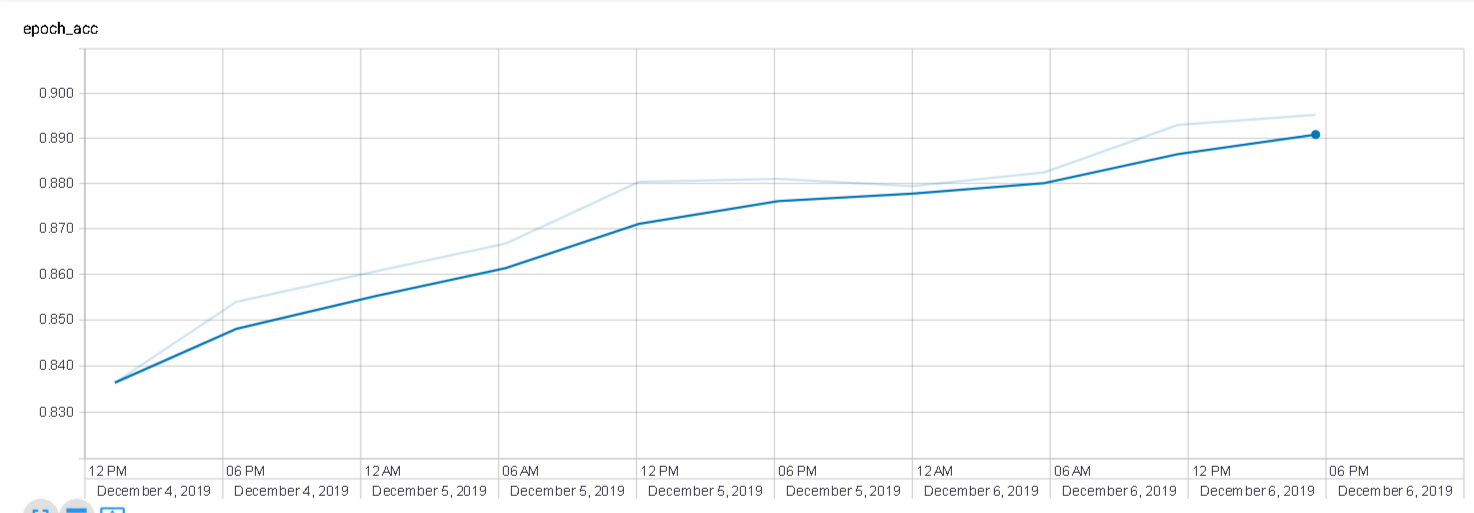

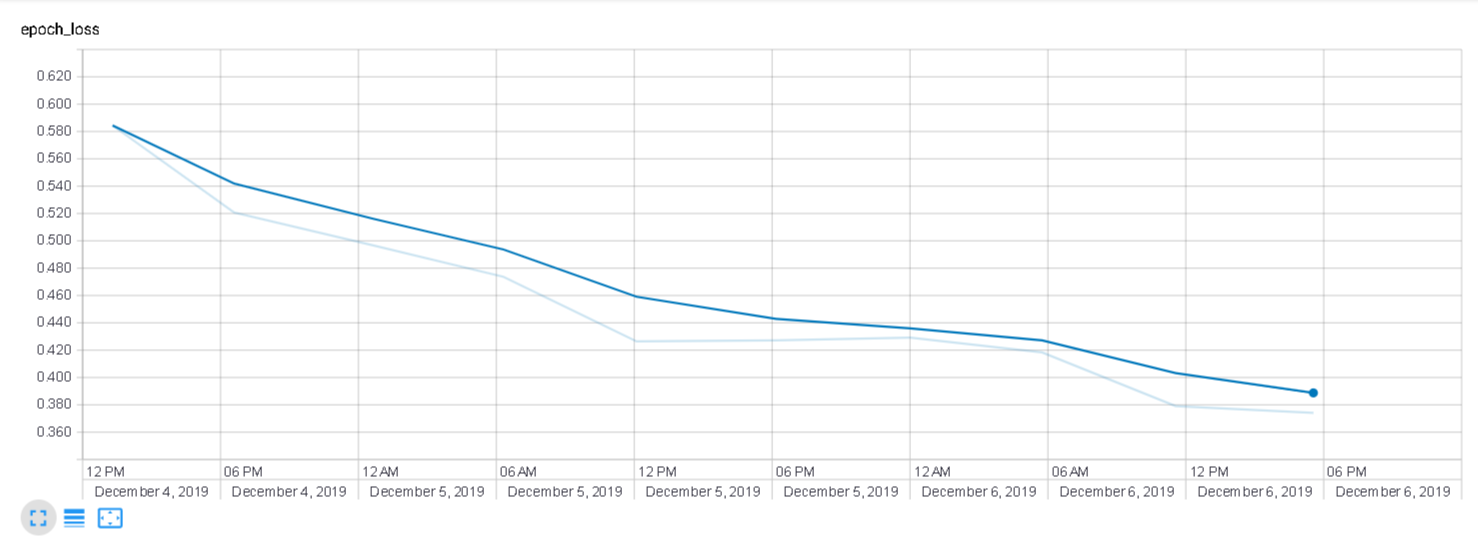

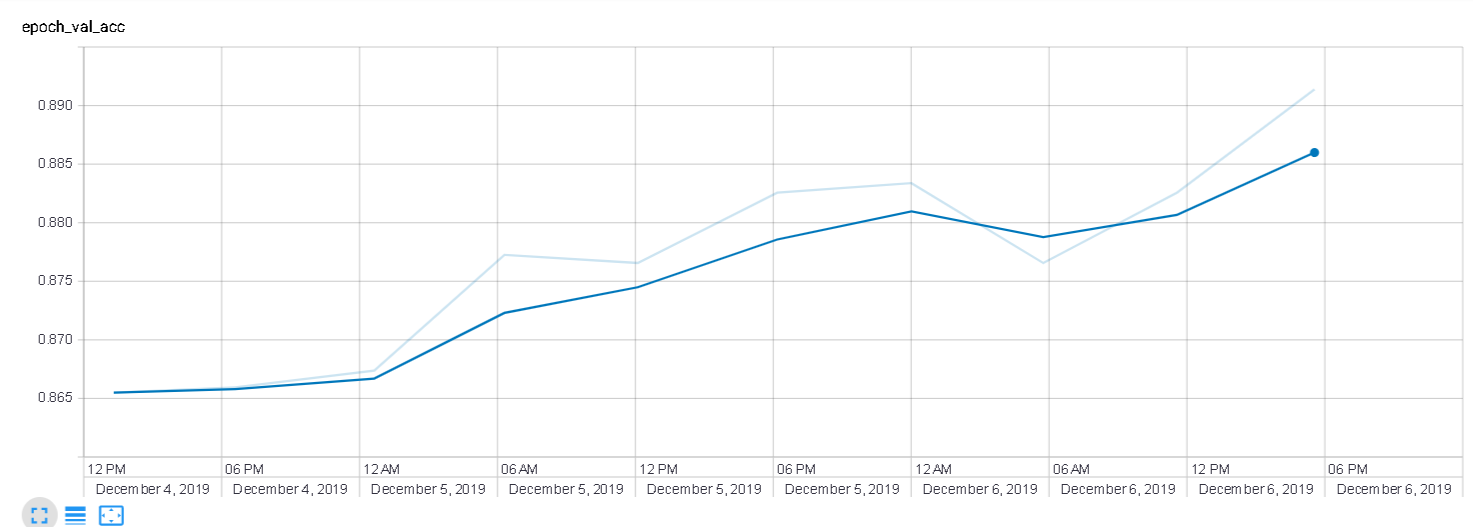

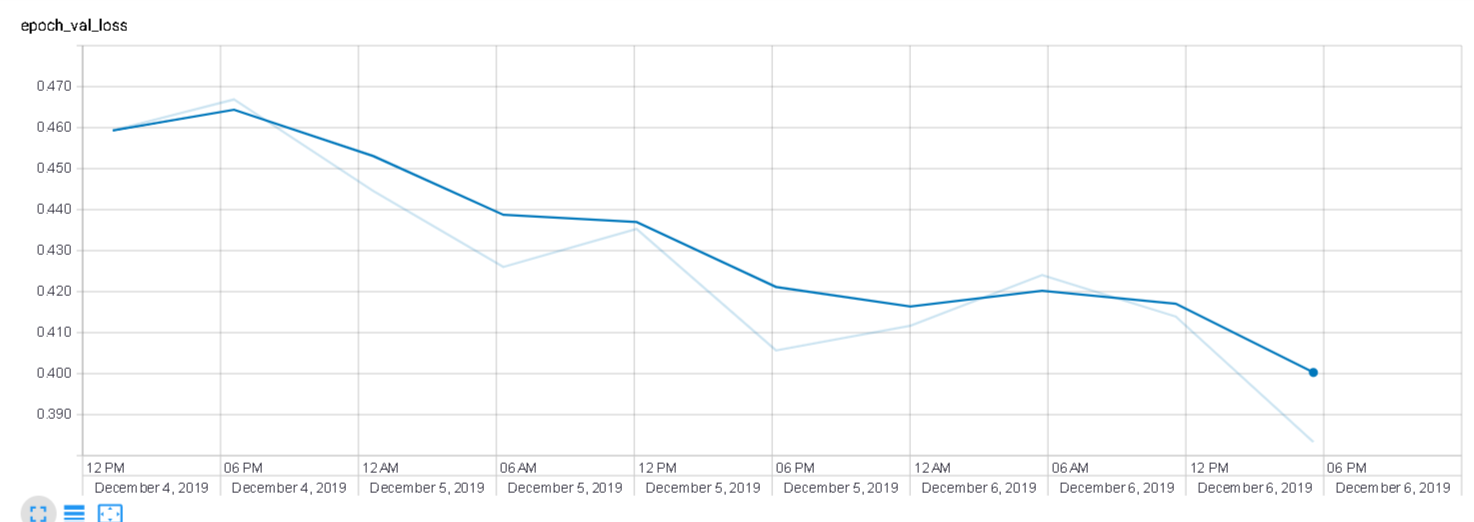

#### 6.2.2. Histograms

As space is constrained, I can not include all histograms. So I am limiting myself here with few histograms for reference. I will include limited histograms for swish activation, sigmoid activation, convolutional layer, depthwise convolutional layer and batch norm layer.

#### 6.2.2.1. Convolutional layer
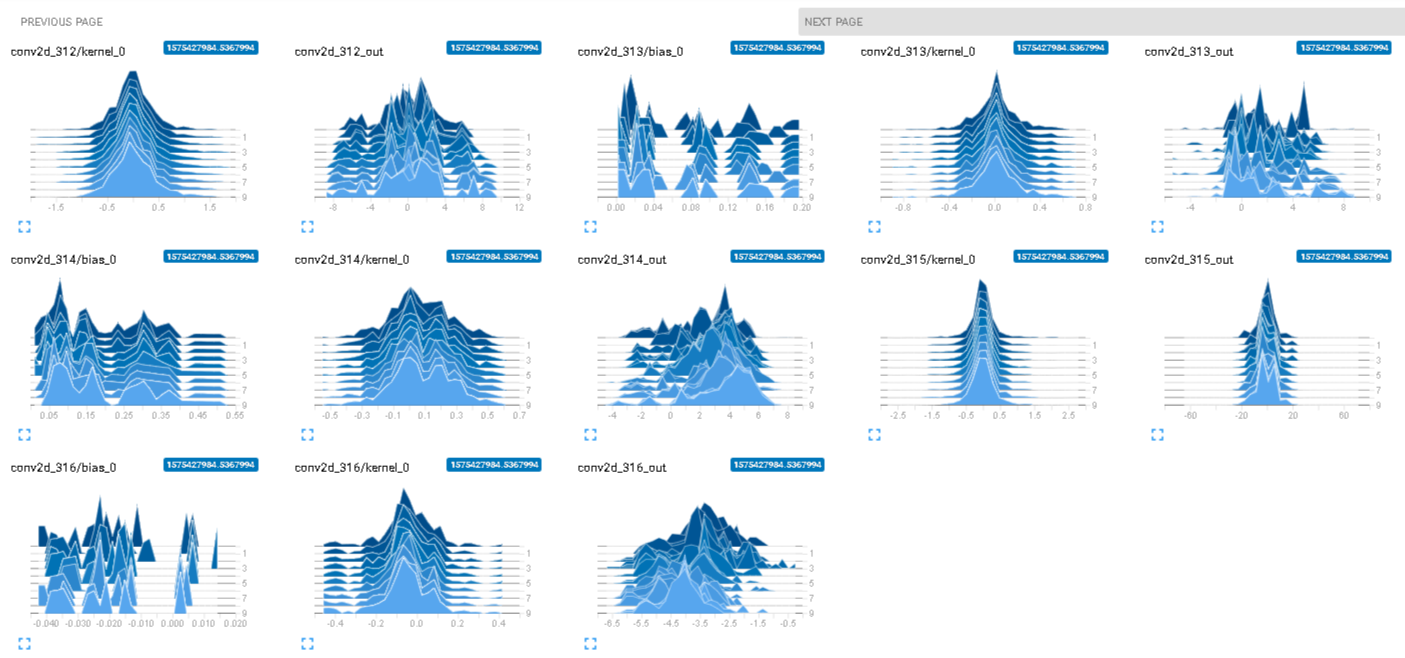

#### 6.2.2.2. Depthwise convolutional layer
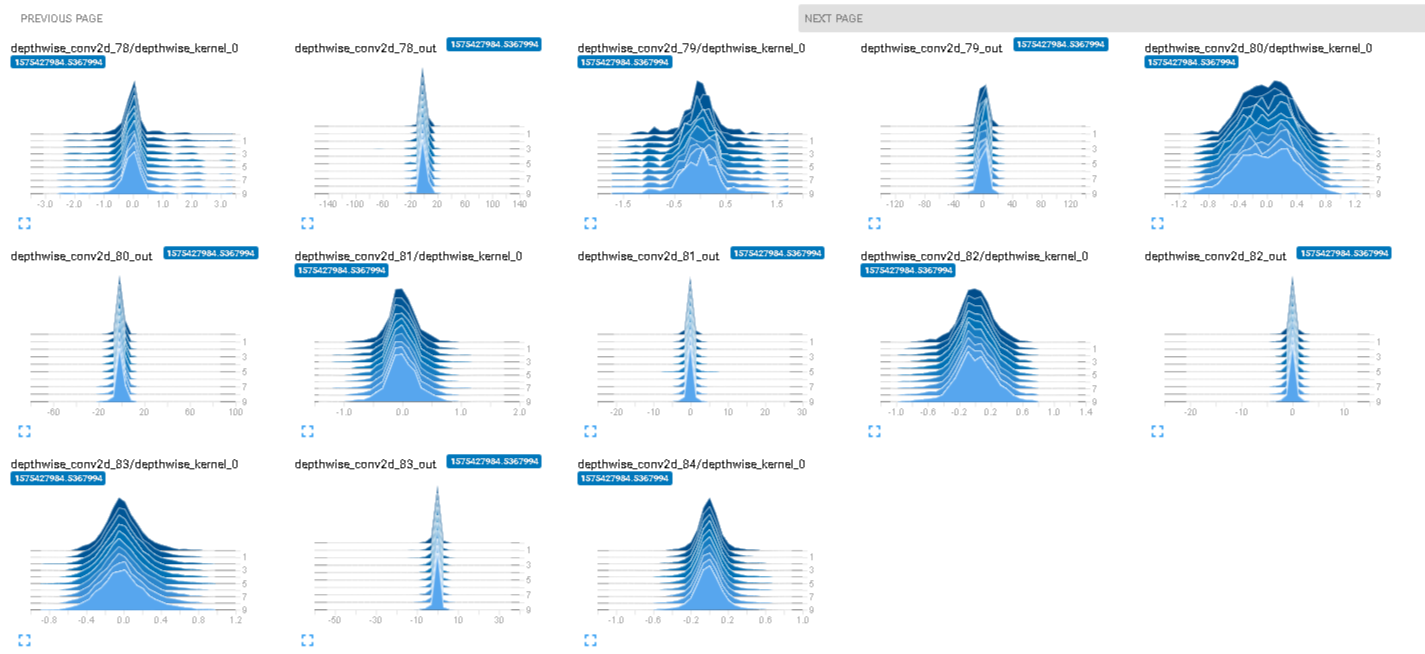

#### 6.2.2.3. BatchNorm layer
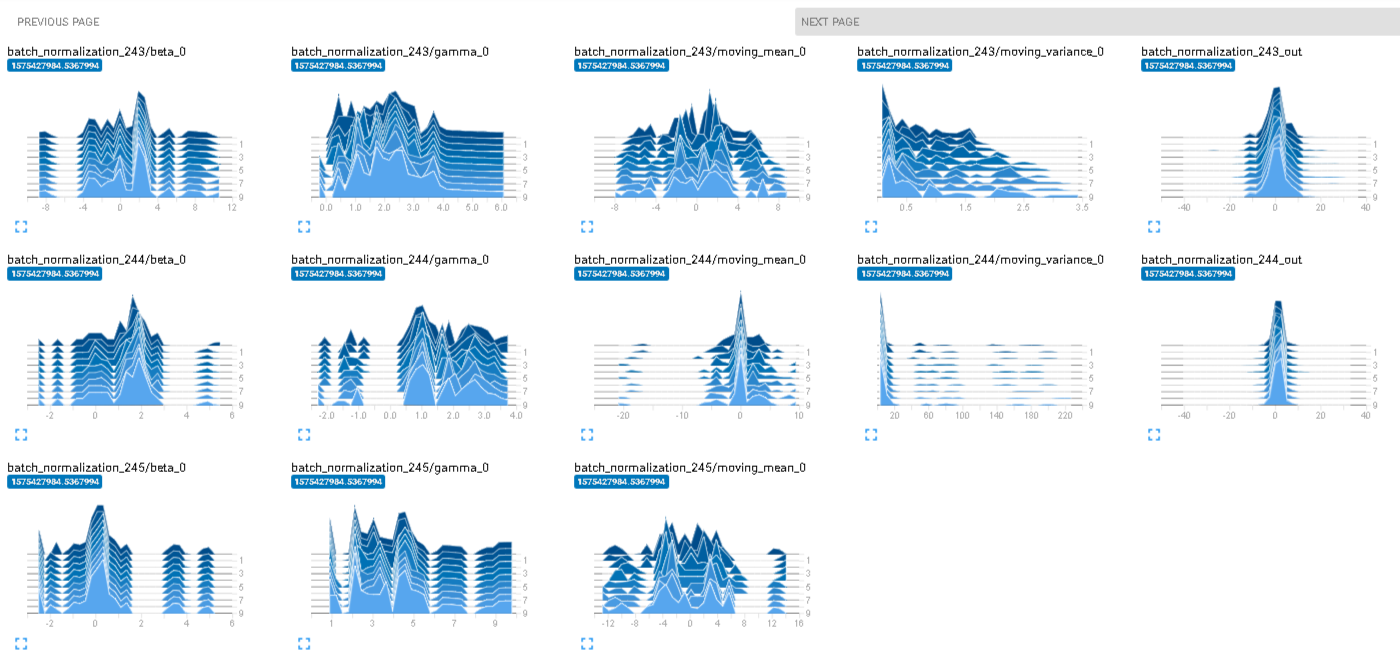

#### 6.2.2.4. Sigmoid activation
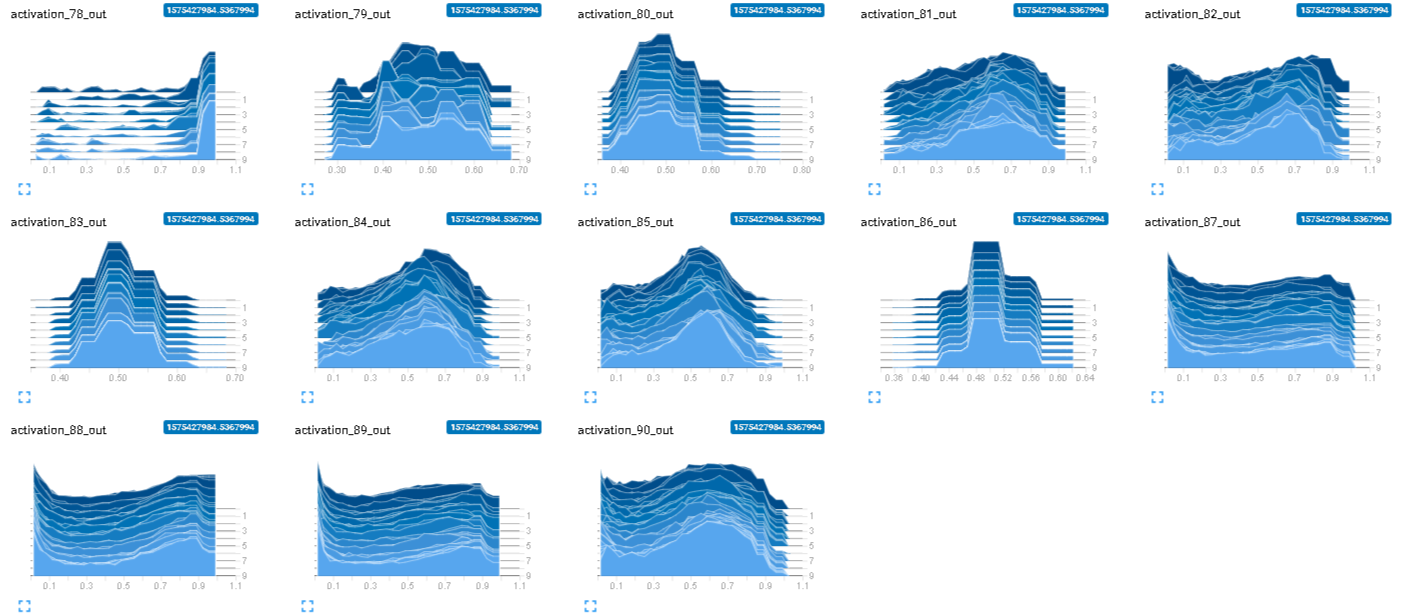

#### 6.2.2.5. Swish activation
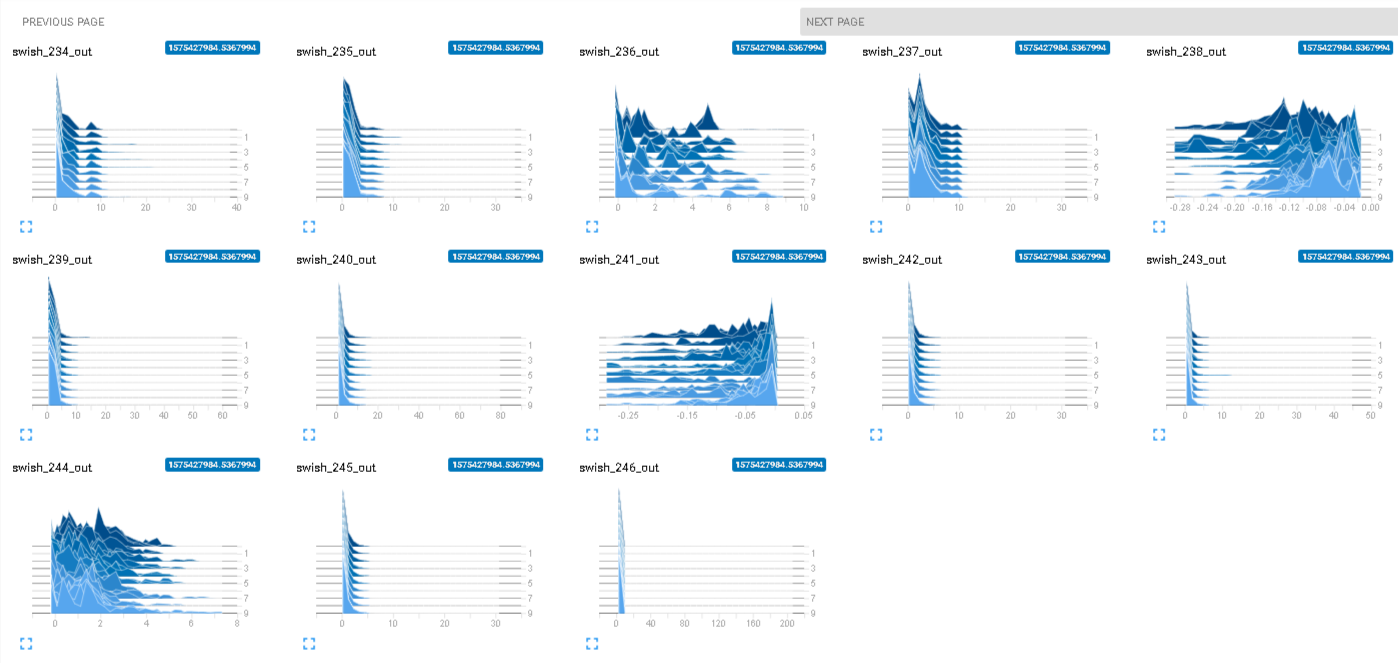

## 7. Conclusion

In [5]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Architecture","Dataset","Validation Accuracy(%)", "Test Accuracy(%)"]

x.add_row(["VGG Transfer Learning", "Subset", 58.09, "-"])
x.add_row(["Inception ResNet Transfer Learning", "Subset", 56.66, "-"])
x.add_row(["EfficientNet B3 Transfer Learning", "Subset", 62.97, "-"])
x.add_row(["EfficientNet B4", "Subset",44.60, "-" ])
x.add_row(["EfficientNet B3 Transfer Learning", "Complete Data", 91.30, 90.70])


print(x)

+------------------------------------+---------------+------------------------+------------------+
|            Architecture            |    Dataset    | Validation Accuracy(%) | Test Accuracy(%) |
+------------------------------------+---------------+------------------------+------------------+
|       VGG Transfer Learning        |     Subset    |         58.09          |        -         |
| Inception ResNet Transfer Learning |     Subset    |         56.66          |        -         |
| EfficientNet B3 Transfer Learning  |     Subset    |         62.97          |        -         |
|          EfficientNet B4           |     Subset    |          44.6          |        -         |
| EfficientNet B3 Transfer Learning  | Complete Data |          91.3          |       90.7       |
+------------------------------------+---------------+------------------------+------------------+


In [6]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import  Model
from tensorflow.keras.optimizers import RMSprop, Adam

In [17]:
img_width, img_height = 300,300
batch_size = 8

model = ENet3b(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3), pooling='avg')


x = model.output
#x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.75)(x)
x = Dense(256, activation="relu", kernel_regularizer=l2())(x)
x = BatchNormalization()(x)
x = Dropout(0.75)(x)
x = Dense(256, activation="relu")(x)
#x = BatchNormalization()(x)
#x = Dropout(0.25)(x)
predictions = Dense(16, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer =Adam(0.0001), metrics=["accuracy"])

model_final.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 150, 150, 40) 1080        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_80 (BatchNo (None, 150, 150, 40) 160         conv2d_104[0][0]                 
__________________________________________________________________________________________________
swish_78 (Swish)                (None, 150, 150, 40) 0           batch_normalization_80[0][0]     
__________________________________________________________________________________________________
depthwise_

__________________________________________________________________________________________________
depthwise_conv2d_31 (DepthwiseC (None, 38, 38, 192)  4800        swish_92[0][0]                   
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 38, 38, 192)  768         depthwise_conv2d_31[0][0]        
__________________________________________________________________________________________________
swish_93 (Swish)                (None, 38, 38, 192)  0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
lambda_31 (Lambda)              (None, 1, 1, 192)    0           swish_93[0][0]                   
__________________________________________________________________________________________________
conv2d_124 (Conv2D)             (None, 1, 1, 8)      1544        lambda_31[0][0]                  
__________

__________________________________________________________________________________________________
swish_108 (Swish)               (None, 19, 19, 576)  0           batch_normalization_110[0][0]    
__________________________________________________________________________________________________
lambda_36 (Lambda)              (None, 1, 1, 576)    0           swish_108[0][0]                  
__________________________________________________________________________________________________
conv2d_144 (Conv2D)             (None, 1, 1, 24)     13848       lambda_36[0][0]                  
__________________________________________________________________________________________________
swish_109 (Swish)               (None, 1, 1, 24)     0           conv2d_144[0][0]                 
__________________________________________________________________________________________________
conv2d_145 (Conv2D)             (None, 1, 1, 576)    14400       swish_109[0][0]                  
__________

batch_normalization_125 (BatchN (None, 19, 19, 816)  3264        depthwise_conv2d_41[0][0]        
__________________________________________________________________________________________________
swish_123 (Swish)               (None, 19, 19, 816)  0           batch_normalization_125[0][0]    
__________________________________________________________________________________________________
lambda_41 (Lambda)              (None, 1, 1, 816)    0           swish_123[0][0]                  
__________________________________________________________________________________________________
conv2d_164 (Conv2D)             (None, 1, 1, 34)     27778       lambda_41[0][0]                  
__________________________________________________________________________________________________
swish_124 (Swish)               (None, 1, 1, 34)     0           conv2d_164[0][0]                 
__________________________________________________________________________________________________
conv2d_165

__________________________________________________________________________________________________
batch_normalization_140 (BatchN (None, 10, 10, 1392) 5568        depthwise_conv2d_46[0][0]        
__________________________________________________________________________________________________
swish_138 (Swish)               (None, 10, 10, 1392) 0           batch_normalization_140[0][0]    
__________________________________________________________________________________________________
lambda_46 (Lambda)              (None, 1, 1, 1392)   0           swish_138[0][0]                  
__________________________________________________________________________________________________
conv2d_184 (Conv2D)             (None, 1, 1, 58)     80794       lambda_46[0][0]                  
__________________________________________________________________________________________________
swish_139 (Swish)               (None, 1, 1, 58)     0           conv2d_184[0][0]                 
__________

depthwise_conv2d_51 (DepthwiseC (None, 10, 10, 2304) 20736       swish_152[0][0]                  
__________________________________________________________________________________________________
batch_normalization_155 (BatchN (None, 10, 10, 2304) 9216        depthwise_conv2d_51[0][0]        
__________________________________________________________________________________________________
swish_153 (Swish)               (None, 10, 10, 2304) 0           batch_normalization_155[0][0]    
__________________________________________________________________________________________________
lambda_51 (Lambda)              (None, 1, 1, 2304)   0           swish_153[0][0]                  
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 1, 1, 96)     221280      lambda_51[0][0]                  
__________________________________________________________________________________________________
swish_154 

In [18]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1. / 255)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)



train_generator = train_datagen.flow_from_directory(
    'traindata2/',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'valdata2/',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')


Found 16097 images belonging to 16 classes.
Found 7434 images belonging to 16 classes.


In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                              patience=1, min_lr=0.000000001, verbose=1)

mcp_save = ModelCheckpoint('HDF5/DocClassification_TL_{epoch:02d}.hdf5', save_best_only=False,
                           monitor='val_loss', mode='max', verbose=1)

stopng = EarlyStopping(monitor='val_acc', patience=3, verbose=1)

tboard = TensorBoard(log_dir= 'logs/model/b3_1_', write_images=False, histogram_freq=0)

history = model_final.fit_generator(
    train_generator,
    epochs=3,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[mcp_save,stopng,reduce_lr,tboard],
    steps_per_epoch=160//batch_size,
    validation_steps=74 //batch_size)


Epoch 1/3
19/20 [===========================>..] - ETA: 34s - loss: 7.5843 - acc: 0.0000e+ - ETA: 21s - loss: 7.5182 - acc: 0.0625   - ETA: 16s - loss: 7.6074 - acc: 0.12 - ETA: 14s - loss: 7.6131 - acc: 0.15 - ETA: 12s - loss: 7.5525 - acc: 0.17 - ETA: 11s - loss: 7.5454 - acc: 0.16 - ETA: 9s - loss: 7.4239 - acc: 0.1964 - ETA: 8s - loss: 7.6676 - acc: 0.187 - ETA: 7s - loss: 7.6382 - acc: 0.180 - ETA: 7s - loss: 7.5908 - acc: 0.175 - ETA: 6s - loss: 7.6191 - acc: 0.159 - ETA: 5s - loss: 7.7417 - acc: 0.145 - ETA: 4s - loss: 7.7090 - acc: 0.144 - ETA: 4s - loss: 7.7152 - acc: 0.133 - ETA: 3s - loss: 7.6916 - acc: 0.133 - ETA: 2s - loss: 7.6744 - acc: 0.132 - ETA: 1s - loss: 7.7153 - acc: 0.125 - ETA: 1s - loss: 7.7681 - acc: 0.118 - ETA: 0s - loss: 7.8179 - acc: 0.1118
Epoch 00001: saving model to HDF5/DocClassification_TL_01.hdf5
20/20 [==============================] - 15s 764ms/step - loss: 7.8285 - acc: 0.1063 - val_loss: 7.1462 - val_acc: 0.0417
Epoch 2/3
19/20 [=================

In [11]:
history = model_final.fit_generator(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    verbose=2,
    callbacks=[mcp_save,reduce_lr],
    steps_per_epoch=16097//batch_size,
    validation_steps=7434 //batch_size)

Epoch 1/10

Epoch 00001: saving model to DocClassification_TL_Enetb3_fullData.hdf5
 - 1498s - loss: 3.5338 - acc: 0.5427 - val_loss: 3.4439 - val_acc: 0.5456
Epoch 2/10

Epoch 00002: saving model to DocClassification_TL_Enetb3_fullData.hdf5
 - 1452s - loss: 2.8609 - acc: 0.6137 - val_loss: 3.0703 - val_acc: 0.5697
Epoch 3/10

Epoch 00003: saving model to DocClassification_TL_Enetb3_fullData.hdf5
 - 1457s - loss: 2.3409 - acc: 0.6664 - val_loss: 2.8498 - val_acc: 0.5872
Epoch 4/10

Epoch 00004: saving model to DocClassification_TL_Enetb3_fullData.hdf5
 - 1424s - loss: 1.9688 - acc: 0.7001 - val_loss: 2.4342 - val_acc: 0.6191
Epoch 5/10

Epoch 00005: saving model to DocClassification_TL_Enetb3_fullData.hdf5
 - 1396s - loss: 1.6651 - acc: 0.7348 - val_loss: 2.4948 - val_acc: 0.6204
Epoch 6/10

Epoch 00006: saving model to DocClassification_TL_Enetb3_fullData.hdf5

Epoch 00006: ReduceLROnPlateau reducing learning rate to 3.2999999166349884e-05.
 - 1406s - loss: 1.4505 - acc: 0.7562 - val_l

In [24]:
img_width, img_height = 300,300
batch_size = 8

model = ENet3b(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3), pooling='avg')


x = model.output
#x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.75)(x)
# x = Dense(256, activation="relu", kernel_regularizer=l2())(x)
# x = BatchNormalization()(x)
# x = Dropout(0.75)(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
predictions = Dense(16, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer =Adam(0.0001), metrics=["accuracy"])

model_final.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv2d_208 (Conv2D)             (None, 150, 150, 40) 1080        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_160 (BatchN (None, 150, 150, 40) 160         conv2d_208[0][0]                 
__________________________________________________________________________________________________
swish_156 (Swish)               (None, 150, 150, 40) 0           batch_normalization_160[0][0]    
__________________________________________________________________________________________________
depthwise_

__________________________________________________________________________________________________
depthwise_conv2d_57 (DepthwiseC (None, 38, 38, 192)  4800        swish_170[0][0]                  
__________________________________________________________________________________________________
batch_normalization_175 (BatchN (None, 38, 38, 192)  768         depthwise_conv2d_57[0][0]        
__________________________________________________________________________________________________
swish_171 (Swish)               (None, 38, 38, 192)  0           batch_normalization_175[0][0]    
__________________________________________________________________________________________________
lambda_57 (Lambda)              (None, 1, 1, 192)    0           swish_171[0][0]                  
__________________________________________________________________________________________________
conv2d_228 (Conv2D)             (None, 1, 1, 8)      1544        lambda_57[0][0]                  
__________

__________________________________________________________________________________________________
swish_186 (Swish)               (None, 19, 19, 576)  0           batch_normalization_190[0][0]    
__________________________________________________________________________________________________
lambda_62 (Lambda)              (None, 1, 1, 576)    0           swish_186[0][0]                  
__________________________________________________________________________________________________
conv2d_248 (Conv2D)             (None, 1, 1, 24)     13848       lambda_62[0][0]                  
__________________________________________________________________________________________________
swish_187 (Swish)               (None, 1, 1, 24)     0           conv2d_248[0][0]                 
__________________________________________________________________________________________________
conv2d_249 (Conv2D)             (None, 1, 1, 576)    14400       swish_187[0][0]                  
__________

batch_normalization_205 (BatchN (None, 19, 19, 816)  3264        depthwise_conv2d_67[0][0]        
__________________________________________________________________________________________________
swish_201 (Swish)               (None, 19, 19, 816)  0           batch_normalization_205[0][0]    
__________________________________________________________________________________________________
lambda_67 (Lambda)              (None, 1, 1, 816)    0           swish_201[0][0]                  
__________________________________________________________________________________________________
conv2d_268 (Conv2D)             (None, 1, 1, 34)     27778       lambda_67[0][0]                  
__________________________________________________________________________________________________
swish_202 (Swish)               (None, 1, 1, 34)     0           conv2d_268[0][0]                 
__________________________________________________________________________________________________
conv2d_269

__________________________________________________________________________________________________
batch_normalization_220 (BatchN (None, 10, 10, 1392) 5568        depthwise_conv2d_72[0][0]        
__________________________________________________________________________________________________
swish_216 (Swish)               (None, 10, 10, 1392) 0           batch_normalization_220[0][0]    
__________________________________________________________________________________________________
lambda_72 (Lambda)              (None, 1, 1, 1392)   0           swish_216[0][0]                  
__________________________________________________________________________________________________
conv2d_288 (Conv2D)             (None, 1, 1, 58)     80794       lambda_72[0][0]                  
__________________________________________________________________________________________________
swish_217 (Swish)               (None, 1, 1, 58)     0           conv2d_288[0][0]                 
__________

depthwise_conv2d_77 (DepthwiseC (None, 10, 10, 2304) 20736       swish_230[0][0]                  
__________________________________________________________________________________________________
batch_normalization_235 (BatchN (None, 10, 10, 2304) 9216        depthwise_conv2d_77[0][0]        
__________________________________________________________________________________________________
swish_231 (Swish)               (None, 10, 10, 2304) 0           batch_normalization_235[0][0]    
__________________________________________________________________________________________________
lambda_77 (Lambda)              (None, 1, 1, 2304)   0           swish_231[0][0]                  
__________________________________________________________________________________________________
conv2d_308 (Conv2D)             (None, 1, 1, 96)     221280      lambda_77[0][0]                  
__________________________________________________________________________________________________
swish_232 

In [25]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1. / 255)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)



train_generator = train_datagen.flow_from_directory(
    'traindata2/',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'valdata2/',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')


Found 16097 images belonging to 16 classes.
Found 7434 images belonging to 16 classes.


In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                              patience=1, min_lr=0.000000001, verbose=1)

mcp_save = ModelCheckpoint('HDF5/DocClassification_TL_{epoch:02d}.hdf5', save_best_only=False,
                           monitor='val_loss', mode='max', verbose=1)

stopng = EarlyStopping(monitor='val_acc', patience=3, verbose=1)

tboard = TensorBoard(log_dir= 'logs/model/b3_1_', write_images=False, histogram_freq=0)

history = model_final.fit_generator(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    verbose=2,
    #callbacks=[mcp_save,stopng,reduce_lr,tboard],
    steps_per_epoch=16000//batch_size,
    validation_steps=7400 //batch_size)


Epoch 1/10
 - 1459s - loss: 2.1846 - acc: 0.3781 - val_loss: 1.7239 - val_acc: 0.5093
Epoch 2/10
 - 1442s - loss: 1.4451 - acc: 0.5814 - val_loss: 1.6856 - val_acc: 0.5727
Epoch 3/10
 - 1414s - loss: 1.1495 - acc: 0.6684 - val_loss: 1.4507 - val_acc: 0.6277
Epoch 4/10
 - 1407s - loss: 0.9532 - acc: 0.7177 - val_loss: 1.5720 - val_acc: 0.6250
Epoch 5/10
 - 1418s - loss: 0.8216 - acc: 0.7572 - val_loss: 1.6138 - val_acc: 0.6319
Epoch 6/10
 - 1437s - loss: 0.7160 - acc: 0.7883 - val_loss: 1.5575 - val_acc: 0.6350
Epoch 7/10
 - 1439s - loss: 0.6259 - acc: 0.8121 - val_loss: 1.5711 - val_acc: 0.6415
Epoch 8/10
 - 1450s - loss: 0.5482 - acc: 0.8323 - val_loss: 1.6516 - val_acc: 0.6458
Epoch 9/10
 - 1444s - loss: 0.4732 - acc: 0.8553 - val_loss: 1.5283 - val_acc: 0.6572
Epoch 10/10
 - 1463s - loss: 0.4173 - acc: 0.8721 - val_loss: 1.7174 - val_acc: 0.6392


In [31]:
img_width, img_height = 300,300
batch_size = 7

model = ENet3b(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3), pooling='avg')


x = model.output
#x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.75)(x)
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.75)(x)
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
predictions = Dense(16, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer =Adam(0.0001), metrics=["accuracy"])

model_final.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv2d_416 (Conv2D)             (None, 150, 150, 40) 1080        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_321 (BatchN (None, 150, 150, 40) 160         conv2d_416[0][0]                 
__________________________________________________________________________________________________
swish_312 (Swish)               (None, 150, 150, 40) 0           batch_normalization_321[0][0]    
__________________________________________________________________________________________________
depthwise_

__________________________________________________________________________________________________
depthwise_conv2d_109 (Depthwise (None, 38, 38, 192)  4800        swish_326[0][0]                  
__________________________________________________________________________________________________
batch_normalization_336 (BatchN (None, 38, 38, 192)  768         depthwise_conv2d_109[0][0]       
__________________________________________________________________________________________________
swish_327 (Swish)               (None, 38, 38, 192)  0           batch_normalization_336[0][0]    
__________________________________________________________________________________________________
lambda_109 (Lambda)             (None, 1, 1, 192)    0           swish_327[0][0]                  
__________________________________________________________________________________________________
conv2d_436 (Conv2D)             (None, 1, 1, 8)      1544        lambda_109[0][0]                 
__________

__________________________________________________________________________________________________
swish_342 (Swish)               (None, 19, 19, 576)  0           batch_normalization_351[0][0]    
__________________________________________________________________________________________________
lambda_114 (Lambda)             (None, 1, 1, 576)    0           swish_342[0][0]                  
__________________________________________________________________________________________________
conv2d_456 (Conv2D)             (None, 1, 1, 24)     13848       lambda_114[0][0]                 
__________________________________________________________________________________________________
swish_343 (Swish)               (None, 1, 1, 24)     0           conv2d_456[0][0]                 
__________________________________________________________________________________________________
conv2d_457 (Conv2D)             (None, 1, 1, 576)    14400       swish_343[0][0]                  
__________

batch_normalization_366 (BatchN (None, 19, 19, 816)  3264        depthwise_conv2d_119[0][0]       
__________________________________________________________________________________________________
swish_357 (Swish)               (None, 19, 19, 816)  0           batch_normalization_366[0][0]    
__________________________________________________________________________________________________
lambda_119 (Lambda)             (None, 1, 1, 816)    0           swish_357[0][0]                  
__________________________________________________________________________________________________
conv2d_476 (Conv2D)             (None, 1, 1, 34)     27778       lambda_119[0][0]                 
__________________________________________________________________________________________________
swish_358 (Swish)               (None, 1, 1, 34)     0           conv2d_476[0][0]                 
__________________________________________________________________________________________________
conv2d_477

__________________________________________________________________________________________________
batch_normalization_381 (BatchN (None, 10, 10, 1392) 5568        depthwise_conv2d_124[0][0]       
__________________________________________________________________________________________________
swish_372 (Swish)               (None, 10, 10, 1392) 0           batch_normalization_381[0][0]    
__________________________________________________________________________________________________
lambda_124 (Lambda)             (None, 1, 1, 1392)   0           swish_372[0][0]                  
__________________________________________________________________________________________________
conv2d_496 (Conv2D)             (None, 1, 1, 58)     80794       lambda_124[0][0]                 
__________________________________________________________________________________________________
swish_373 (Swish)               (None, 1, 1, 58)     0           conv2d_496[0][0]                 
__________

depthwise_conv2d_129 (Depthwise (None, 10, 10, 2304) 20736       swish_386[0][0]                  
__________________________________________________________________________________________________
batch_normalization_396 (BatchN (None, 10, 10, 2304) 9216        depthwise_conv2d_129[0][0]       
__________________________________________________________________________________________________
swish_387 (Swish)               (None, 10, 10, 2304) 0           batch_normalization_396[0][0]    
__________________________________________________________________________________________________
lambda_129 (Lambda)             (None, 1, 1, 2304)   0           swish_387[0][0]                  
__________________________________________________________________________________________________
conv2d_516 (Conv2D)             (None, 1, 1, 96)     221280      lambda_129[0][0]                 
__________________________________________________________________________________________________
swish_388 

In [32]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1. / 255)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)



train_generator = train_datagen.flow_from_directory(
    'traindata2/',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'valdata2/',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')


Found 16097 images belonging to 16 classes.
Found 7434 images belonging to 16 classes.


In [33]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                              patience=1, min_lr=0.000000001, verbose=1)

mcp_save = ModelCheckpoint('HDF5/DocClassification_TL_{epoch:02d}.hdf5', save_best_only=False,
                           monitor='val_loss', mode='max', verbose=1)

stopng = EarlyStopping(monitor='val_acc', patience=3, verbose=1)

tboard = TensorBoard(log_dir= 'logs/model/b3_1_', write_images=False, histogram_freq=0)

history = model_final.fit_generator(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    verbose=2,
    #callbacks=[mcp_save,stopng,reduce_lr,tboard],
    steps_per_epoch=16000//batch_size,
    validation_steps=7400 //batch_size)


Epoch 1/10
 - 1601s - loss: 3.3161 - acc: 0.0957 - val_loss: 2.5735 - val_acc: 0.1812
Epoch 2/10
 - 1580s - loss: 2.7232 - acc: 0.1882 - val_loss: 2.1490 - val_acc: 0.3217
Epoch 3/10
 - 1585s - loss: 2.3562 - acc: 0.2666 - val_loss: 1.9298 - val_acc: 0.3913
Epoch 4/10
 - 1817s - loss: 2.1007 - acc: 0.3470 - val_loss: 1.7609 - val_acc: 0.4728
Epoch 5/10
 - 1950s - loss: 1.9010 - acc: 0.4004 - val_loss: 1.6354 - val_acc: 0.5041
Epoch 6/10
 - 1676s - loss: 1.7169 - acc: 0.4624 - val_loss: 1.6105 - val_acc: 0.5525
Epoch 7/10
 - 1620s - loss: 1.5793 - acc: 0.5119 - val_loss: 1.4871 - val_acc: 0.5756
Epoch 8/10
 - 1613s - loss: 1.4747 - acc: 0.5515 - val_loss: 1.4300 - val_acc: 0.5936
Epoch 9/10
 - 1609s - loss: 1.3469 - acc: 0.6005 - val_loss: 1.4778 - val_acc: 0.5948
Epoch 10/10
 - 1600s - loss: 1.2615 - acc: 0.6259 - val_loss: 1.4307 - val_acc: 0.6068


In [ ]:
history = model_final.fit_generator(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    verbose=2,
    #callbacks=[mcp_save,stopng,reduce_lr,tboard],
    steps_per_epoch=16000//batch_size,
    validation_steps=7400 //batch_size)


Epoch 1/10
 - 1542s - loss: 1.1339 - acc: 0.6701 - val_loss: 1.4737 - val_acc: 0.6167
Epoch 2/10
 - 1573s - loss: 1.1101 - acc: 0.6839 - val_loss: 1.4997 - val_acc: 0.6133
Epoch 3/10
 - 1580s - loss: 1.0395 - acc: 0.7043 - val_loss: 1.4905 - val_acc: 0.6256
Epoch 4/10


In [7]:
img_width, img_height = 300,300
batch_size = 8

model = ENet3b(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3), pooling='avg')


x = model.output
x = BatchNormalization()(x)
x = Dropout(0.75)(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
predictions = Dense(16, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer= Adam(0.0003), metrics=["accuracy"])

model_final.summary()


Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 150, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 150, 150, 40) 160         conv2d[0][0]                     
__________________________________________________________________________________________________
swish (Swish)                   (None, 150, 150, 40) 0           batch_normalization[0][0]        
____

batch_normalization_14 (BatchNo (None, 75, 75, 192)  768         conv2d_19[0][0]                  
__________________________________________________________________________________________________
swish_14 (Swish)                (None, 75, 75, 192)  0           batch_normalization_14[0][0]     
__________________________________________________________________________________________________
depthwise_conv2d_5 (DepthwiseCo (None, 38, 38, 192)  4800        swish_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 38, 38, 192)  768         depthwise_conv2d_5[0][0]         
__________________________________________________________________________________________________
swish_15 (Swish)                (None, 38, 38, 192)  0           batch_normalization_15[0][0]     
__________________________________________________________________________________________________
lambda_5 (

depthwise_conv2d_10 (DepthwiseC (None, 19, 19, 576)  5184        swish_29[0][0]                   
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 19, 19, 576)  2304        depthwise_conv2d_10[0][0]        
__________________________________________________________________________________________________
swish_30 (Swish)                (None, 19, 19, 576)  0           batch_normalization_30[0][0]     
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 1, 1, 576)    0           swish_30[0][0]                   
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 1, 1, 24)     13848       lambda_10[0][0]                  
__________________________________________________________________________________________________
swish_31 (

__________________________________________________________________________________________________
depthwise_conv2d_15 (DepthwiseC (None, 19, 19, 816)  20400       swish_44[0][0]                   
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 19, 19, 816)  3264        depthwise_conv2d_15[0][0]        
__________________________________________________________________________________________________
swish_45 (Swish)                (None, 19, 19, 816)  0           batch_normalization_45[0][0]     
__________________________________________________________________________________________________
lambda_15 (Lambda)              (None, 1, 1, 816)    0           swish_45[0][0]                   
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 1, 1, 34)     27778       lambda_15[0][0]                  
__________

swish_59 (Swish)                (None, 10, 10, 1392) 0           batch_normalization_59[0][0]     
__________________________________________________________________________________________________
depthwise_conv2d_20 (DepthwiseC (None, 10, 10, 1392) 34800       swish_59[0][0]                   
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 10, 10, 1392) 5568        depthwise_conv2d_20[0][0]        
__________________________________________________________________________________________________
swish_60 (Swish)                (None, 10, 10, 1392) 0           batch_normalization_60[0][0]     
__________________________________________________________________________________________________
lambda_20 (Lambda)              (None, 1, 1, 1392)   0           swish_60[0][0]                   
__________________________________________________________________________________________________
conv2d_80 

__________________________________________________________________________________________________
swish_74 (Swish)                (None, 10, 10, 2304) 0           batch_normalization_74[0][0]     
__________________________________________________________________________________________________
depthwise_conv2d_25 (DepthwiseC (None, 10, 10, 2304) 20736       swish_74[0][0]                   
__________________________________________________________________________________________________
batch_normalization_75 (BatchNo (None, 10, 10, 2304) 9216        depthwise_conv2d_25[0][0]        
__________________________________________________________________________________________________
swish_75 (Swish)                (None, 10, 10, 2304) 0           batch_normalization_75[0][0]     
__________________________________________________________________________________________________
lambda_25 (Lambda)              (None, 1, 1, 2304)   0           swish_75[0][0]                   
__________

In [9]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1. / 255)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)



train_generator = train_datagen.flow_from_directory(
    'traindata/',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'valdata/',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')


Found 319835 images belonging to 16 classes.
Found 39995 images belonging to 16 classes.


In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                              patience=1, min_lr=0.000000001, verbose=1)

mcp_save = ModelCheckpoint('HDF5/DocClassification_TL-B3_{epoch:02d}.hdf5', save_best_only=False,
                           monitor='val_loss', mode='min', verbose=1)

stopng = EarlyStopping(monitor='val_acc', patience=3, verbose=1)

tboard = TensorBoard(log_dir= 'logs/model/b3_2', write_graph=False)

history = model_final.fit_generator(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    verbose=2,
    callbacks=[mcp_save,stopng,reduce_lr,tboard],
    steps_per_epoch=319835//batch_size,
    validation_steps=39995//batch_size)


Epoch 1/15

Epoch 00001: saving model to HDF5/DocClassification_TL-B3_01.hdf5
 - 32953s - loss: 0.8808 - acc: 0.7461 - val_loss: 0.4671 - val_acc: 0.8664
Epoch 2/15

Epoch 00002: saving model to HDF5/DocClassification_TL-B3_02.hdf5
 - 34141s - loss: 0.5302 - acc: 0.8484 - val_loss: 0.4359 - val_acc: 0.8739
Epoch 3/15

Epoch 00003: saving model to HDF5/DocClassification_TL-B3_03.hdf5
 - 33979s - loss: 0.4461 - acc: 0.8729 - val_loss: 0.3922 - val_acc: 0.8882
Epoch 4/15

Epoch 00004: saving model to HDF5/DocClassification_TL-B3_04.hdf5
 - 33914s - loss: 0.3973 - acc: 0.8864 - val_loss: 0.3549 - val_acc: 0.8971
Epoch 5/15

Epoch 00005: saving model to HDF5/DocClassification_TL-B3_05.hdf5
 - 34578s - loss: 0.3597 - acc: 0.8969 - val_loss: 0.3437 - val_acc: 0.9000
Epoch 6/15

Epoch 00006: saving model to HDF5/DocClassification_TL-B3_06.hdf5

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.900000470224769e-05.
 - 34269s - loss: 0.3290 - acc: 0.9052 - val_loss: 0.3463 - val_acc: 0.


Epoch 00007: saving model to HDF5/DocClassification_TL-B3_07.hdf5
 - 34425s - loss: 0.2380 - acc: 0.9305 - val_loss: 0.3077 - val_acc: 0.9140
Epoch 8/15

Epoch 00008: saving model to HDF5/DocClassification_TL-B3_08.hdf5

Epoch 00008: ReduceLROnPlateau reducing learning rate to 3.26700014556991e-05.
 - 34687s - loss: 0.1958 - acc: 0.9423 - val_loss: 0.3108 - val_acc: 0.9146
Epoch 9/15

Epoch 00009: saving model to HDF5/DocClassification_TL-B3_09.hdf5

Epoch 00009: ReduceLROnPlateau reducing learning rate to 1.0781100936583243e-05.
 - 34642s - loss: 0.1487 - acc: 0.9564 - val_loss: 0.3200 - val_acc: 0.9174
Epoch 10/15

Epoch 00010: saving model to HDF5/DocClassification_TL-B3_10.hdf5

Epoch 00010: ReduceLROnPlateau reducing learning rate to 3.5577633570937907e-06.
 - 35120s - loss: 0.1269 - acc: 0.9628 - val_loss: 0.3291 - val_acc: 0.9180
Epoch 11/15

Epoch 00011: saving model to HDF5/DocClassification_TL-B3_11.hdf5

Epoch 00011: ReduceLROnPlateau reducing learning rate to 1.17406192885


Epoch 00014: saving model to HDF5/DocClassification_TL-B3_14.hdf5

Epoch 00014: ReduceLROnPlateau reducing learning rate to 4.219226354962302e-08.
 - 35340s - loss: 0.1151 - acc: 0.9656 - val_loss: 0.3286 - val_acc: 0.9181
Epoch 00014: early stopping
